# Исследование случайных графов



### Хочу реализовать все в 1 огромной функции которая будет делать перебор в почти сама, но к ней надо подготовиться и сделать вспомогательные решения

- первым делом напишем генератор распределений


In [2]:
import numpy as np

def sample_normal(n, sigma):
    return np.random.normal(0, sigma, n)

def sample_t(n, df):
    return np.random.standard_t(df, n)

- теперь напишем функции что будут создавать случайные графы


In [3]:
import networkx as nx
from sklearn.neighbors import NearestNeighbors

def build_knn_graph_v2(X, k):
    G = nx.Graph()
    n = len(X)
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(X.reshape(-1, 1))
    indices = nbrs.kneighbors(X.reshape(-1, 1), return_distance=False)
    G.add_nodes_from(range(n))
    edges = [(i, j) for i in range(n) for j in indices[i][1:]]
    G.add_edges_from(edges)
    return G

def build_dist_graph_v2(X, d):
    G = nx.Graph()
    n = len(X)
    G.add_nodes_from(range(n))
    edges = [(i, j) for i in range(n) for j in range(i+1, n) if abs(X[i] - X[j]) <= d]
    G.add_edges_from(edges)
    return G

- с помощью либы networks создадим функции что будут быстро считать характеристики что я выбрал для исследования: число компонент связности и размер максимального независимого множества

In [4]:
def count_connected_components(G):
    return nx.number_connected_components(G)

def max_independent_set_size(G):
    try:
        return len(nx.algorithms.approximation.maximum_independent_set(G))
    except:
        return 0

- также потребуется симуляция построения графа несколько сотен раз

In [5]:
def repeater(sample_func, graph_func, char_func, n_sim, n, *args):
    return np.array([
        char_func(graph_func(sample_func(n, *args)))
        for _ in range(n_sim)
    ])

- и последнее: хочу фукнцию что будет считать мощность и строить пороговое значение 

In [6]:
def metrics(T_H0, T_H1):
    threshold = np.percentile(T_H0, 95)
    power = np.mean(T_H1 > threshold)
    return threshold, power

- сделаем рисовалку графиков

In [7]:
def plot_shifted_bars(T_H0, T_H1, threshold, title, xlabel, ylabel):
    bins = np.arange(min(T_H0.min(), T_H1.min()), max(T_H0.max(), T_H1.max()) + 2) - 0.5

    counts_H0, _ = np.histogram(T_H0, bins=bins)
    counts_H1, _ = np.histogram(T_H1, bins=bins)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    width = 0.4

    plt.figure(figsize=(8, 4))
    plt.bar(bin_centers - width/2, counts_H0, width=width, alpha=0.5, label='H0: Normal', color='blue', align='center')
    plt.bar(bin_centers + width/2, counts_H1, width=width, alpha=0.5, label='H1: Student-t', color='orange', align='center')

    plt.axvline(threshold, color='red', linestyle='--', label=f'Порог (95% H0): {threshold:.2f}')
    plt.title(title)
    plt.xlabel(xlabel)  # Ставим до show
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

- ну вот и основная функция, в чем ее суть: ей передаем массива, перебирающие n, k/d, t0, t1. (все что просили в таске), она строит сразу графики для Dist и Knn графа, выводит мощность и пороговое значение.


In [ ]:
import pandas as pd

def perebiralka(n_values, k_values, d_values, sigma_values, nu_values, n_sim=300):
    summary_results = []

    for n in n_values:
        for sigma in sigma_values:
            for nu in nu_values:

                for k in k_values:
                    print(f"=== KNN: n={n}, k={k}, σ₀={sigma}, ν₁={nu} ===")
                    T_H0 = repeater(sample_normal, lambda X: build_knn_graph_v2(X, k), count_connected_components, n_sim, n, sigma)
                    T_H1 = repeater(sample_t, lambda X: build_knn_graph_v2(X, k), count_connected_components, n_sim, n, nu)
                    threshold, power = metrics(T_H0, T_H1)

                    plot_shifted_bars(T_H0, T_H1, threshold,
                                      title=f"KNN: n={n}, k={k}, σ₀={sigma}, ν₁={nu}",xlabel='Число компонент связности',
                                      ylabel='Частота')
                    print(f"Power (H1): {power:.3f}\n")

                    summary_results.append({
                        'Graph': 'KNN',
                        'n': n,
                        'k/d': k,
                        'σ₀ (H0)': sigma,
                        'ν₁ (H1)': nu,
                        'Threshold (95% H0)': threshold,
                        'Power (H1)': power
                    })

                for d in d_values:
                    print(f"=== DIST: n={n}, d={d}, σ₀={sigma}, ν₁={nu} ===")
                    T_H0 = repeater(sample_normal, lambda X: build_dist_graph_v2(X, d), max_independent_set_size, n_sim, n, sigma)
                    T_H1 = repeater(sample_t, lambda X: build_dist_graph_v2(X, d), max_independent_set_size, n_sim, n, nu)
                    threshold, power = metrics(T_H0, T_H1)

                    plot_shifted_bars(T_H0, T_H1, threshold,
                                      title=f"DIST: n={n}, d={d}, σ₀={sigma}, ν₁={nu}", xlabel='Размер максимального независимого множества',
                                      ylabel='Частота')
                    print(f"Power (H1): {power:.3f}\n")

                    summary_results.append({
                        'Graph': 'DIST',
                        'n': n,
                        'k/d': d,
                        'σ₀ (H0)': sigma,
                        'ν₁ (H1)': nu,
                        'Threshold (95% H0)': threshold,
                        'Power (H1)': power
                    })
    
    return pd.DataFrame(summary_results)

## Перебираем параметры построения графа при фиксированных параметрах распределений СВ

=== KNN: n=100, k=2, σ₀=1, ν₁=3 ===


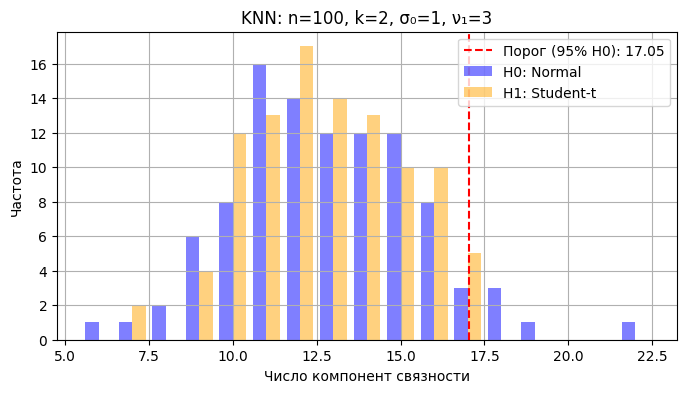

Power (H1): 0.000

=== KNN: n=100, k=3, σ₀=1, ν₁=3 ===


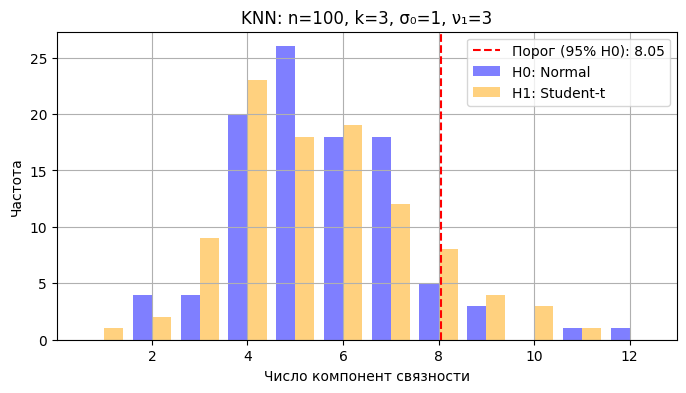

Power (H1): 0.080

=== KNN: n=100, k=4, σ₀=1, ν₁=3 ===


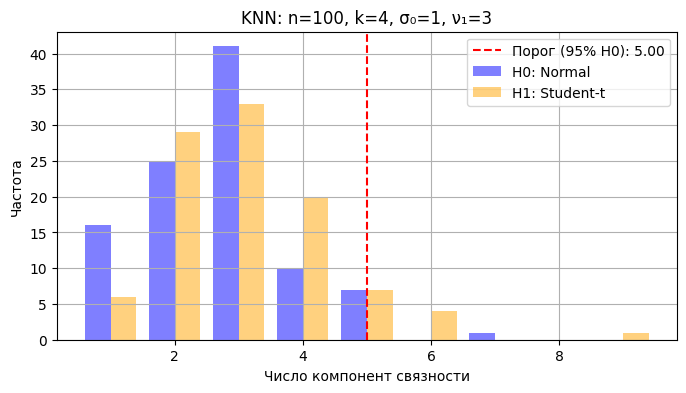

Power (H1): 0.050

=== KNN: n=100, k=5, σ₀=1, ν₁=3 ===


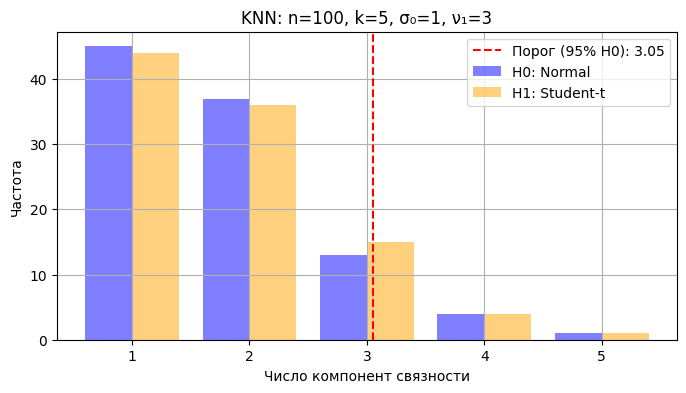

Power (H1): 0.050

=== KNN: n=100, k=10, σ₀=1, ν₁=3 ===


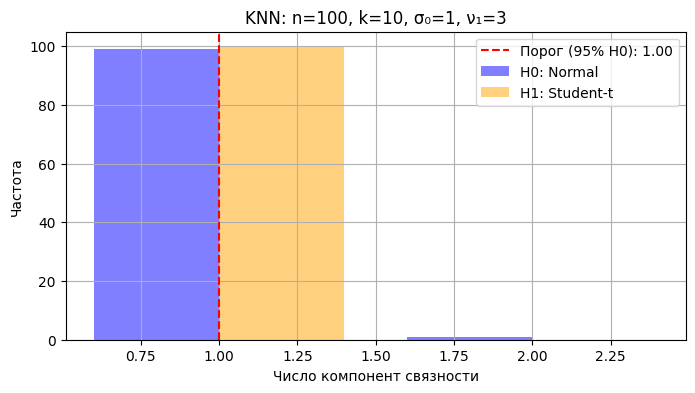

Power (H1): 0.000

=== KNN: n=100, k=20, σ₀=1, ν₁=3 ===


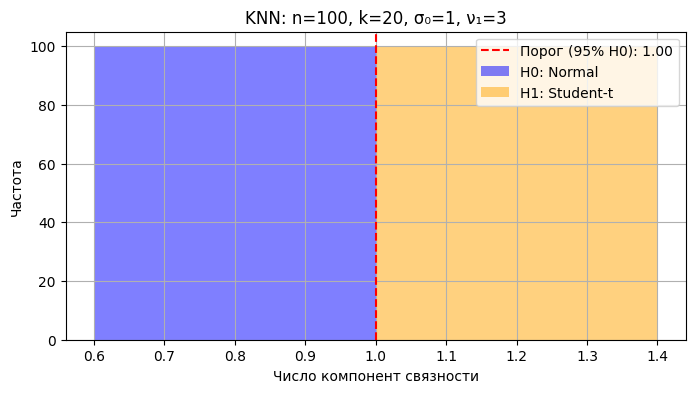

Power (H1): 0.000

=== KNN: n=100, k=40, σ₀=1, ν₁=3 ===


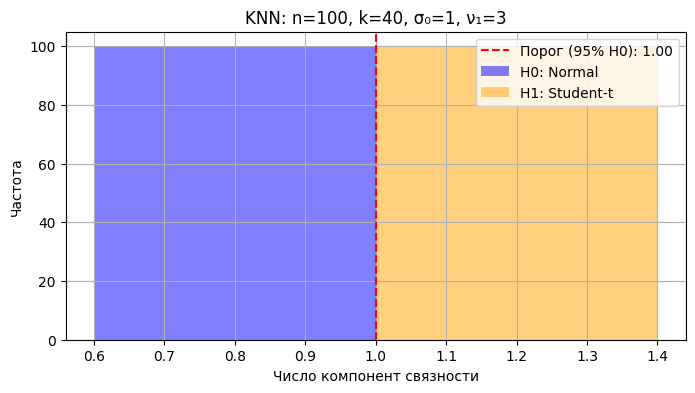

Power (H1): 0.000

=== KNN: n=100, k=80, σ₀=1, ν₁=3 ===


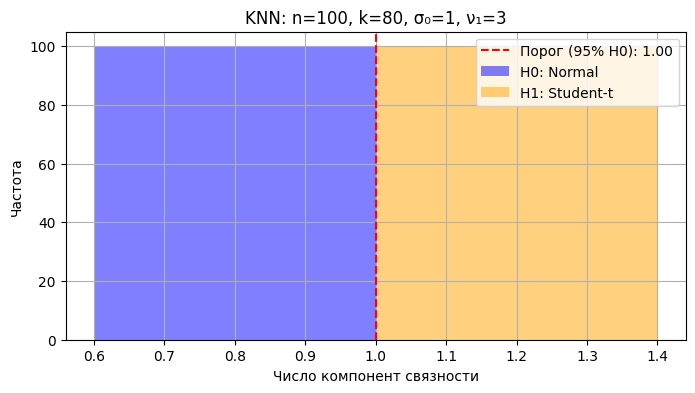

Power (H1): 0.000

=== DIST: n=100, d=0.1, σ₀=1, ν₁=3 ===


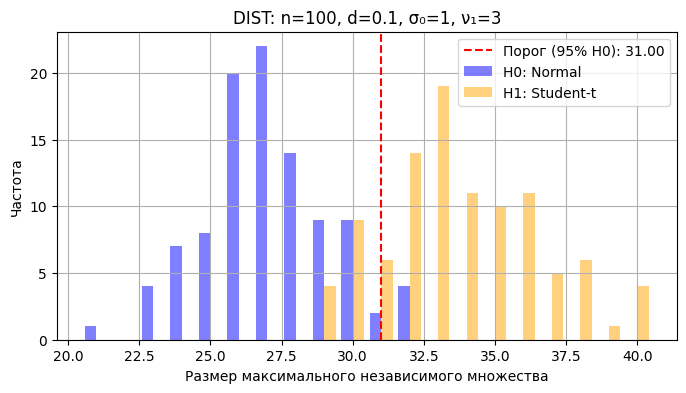

Power (H1): 0.810

=== DIST: n=100, d=0.2, σ₀=1, ν₁=3 ===


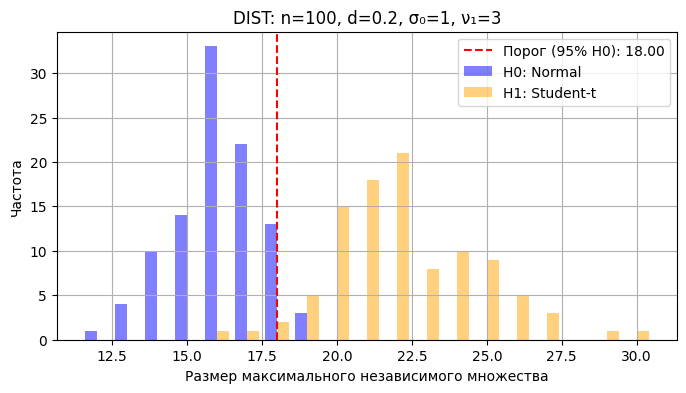

Power (H1): 0.960

=== DIST: n=100, d=0.5, σ₀=1, ν₁=3 ===


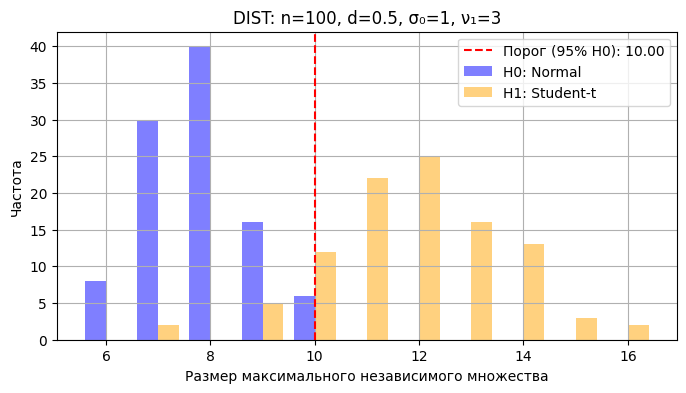

Power (H1): 0.810

=== DIST: n=100, d=1.0, σ₀=1, ν₁=3 ===


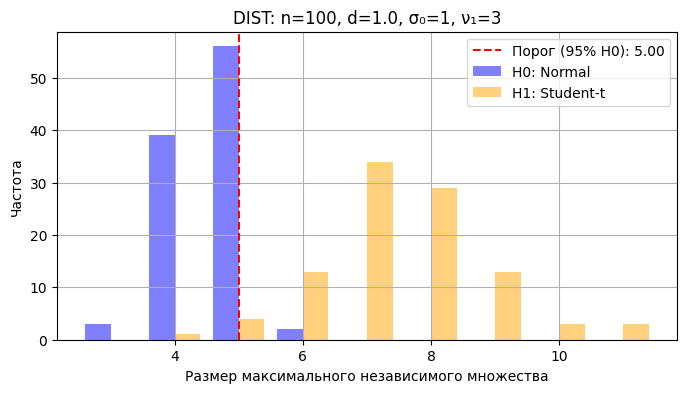

Power (H1): 0.950

=== KNN: n=200, k=2, σ₀=1, ν₁=3 ===


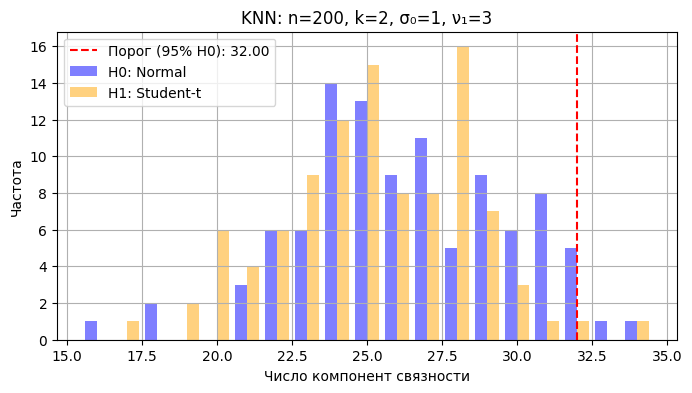

Power (H1): 0.010

=== KNN: n=200, k=3, σ₀=1, ν₁=3 ===


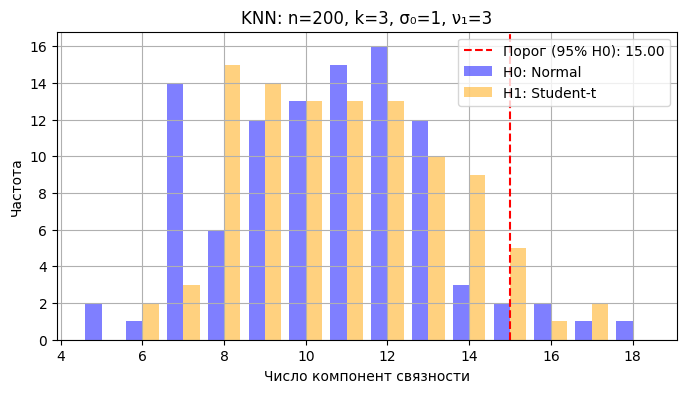

Power (H1): 0.030

=== KNN: n=200, k=4, σ₀=1, ν₁=3 ===


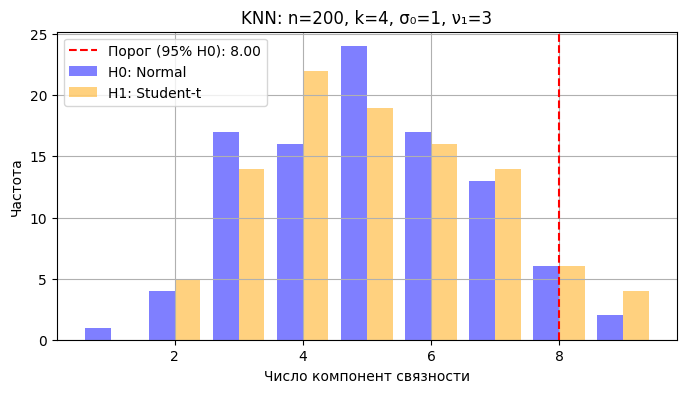

Power (H1): 0.040

=== KNN: n=200, k=5, σ₀=1, ν₁=3 ===


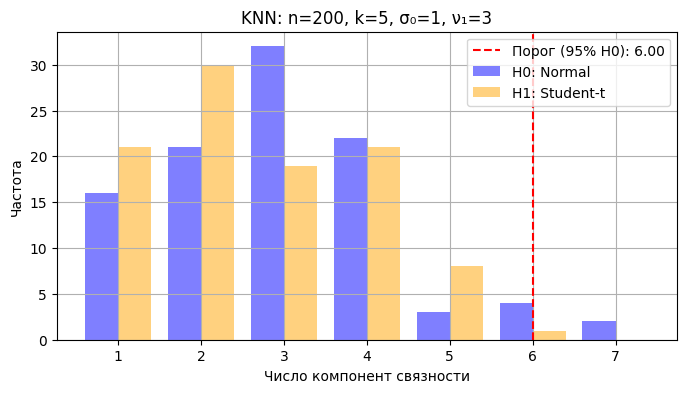

Power (H1): 0.000

=== KNN: n=200, k=10, σ₀=1, ν₁=3 ===


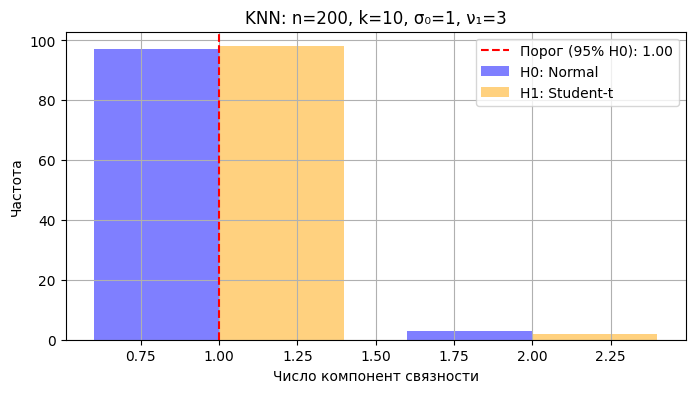

Power (H1): 0.020

=== KNN: n=200, k=20, σ₀=1, ν₁=3 ===


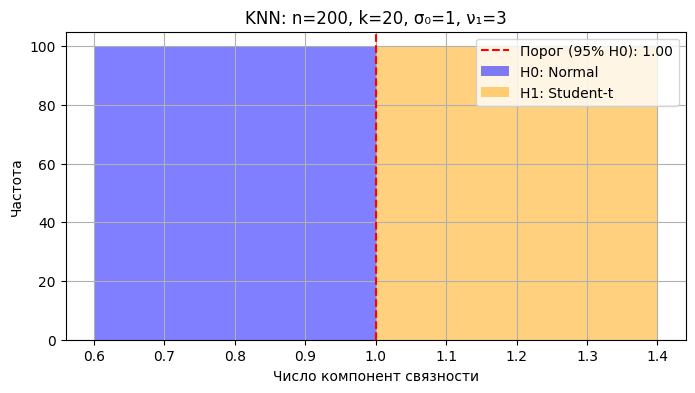

Power (H1): 0.000

=== KNN: n=200, k=40, σ₀=1, ν₁=3 ===


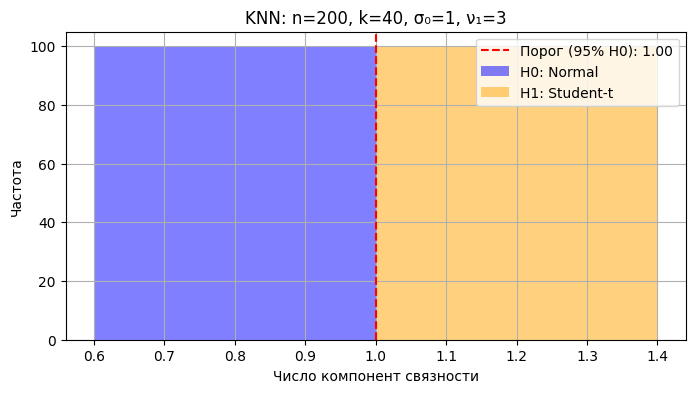

Power (H1): 0.000

=== KNN: n=200, k=80, σ₀=1, ν₁=3 ===


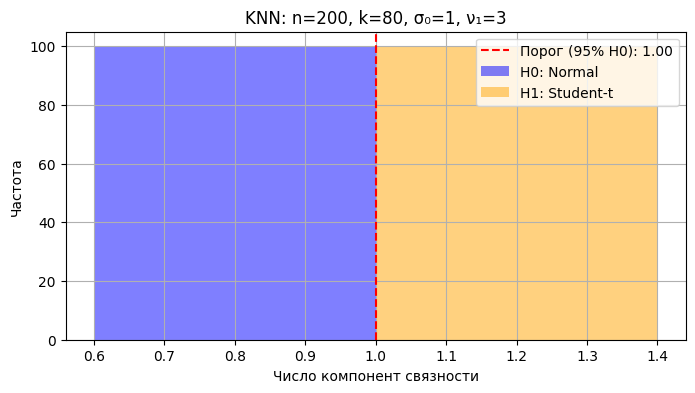

Power (H1): 0.000

=== DIST: n=200, d=0.1, σ₀=1, ν₁=3 ===


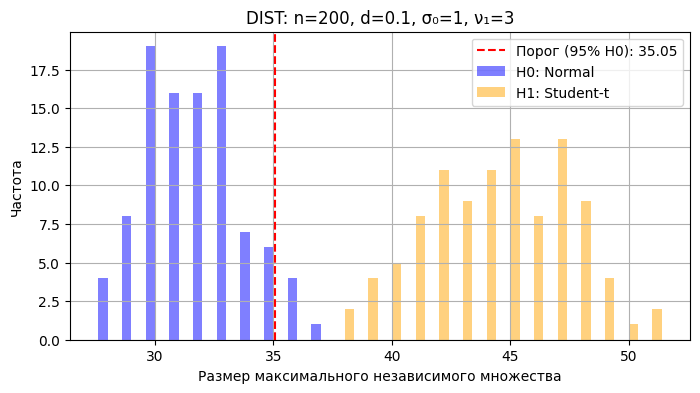

Power (H1): 1.000

=== DIST: n=200, d=0.2, σ₀=1, ν₁=3 ===


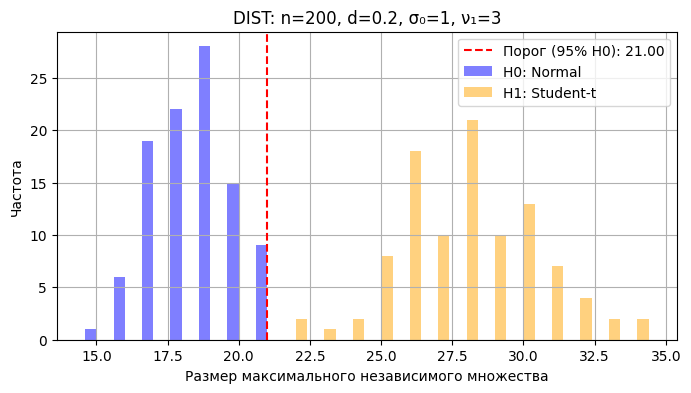

Power (H1): 1.000

=== DIST: n=200, d=0.5, σ₀=1, ν₁=3 ===


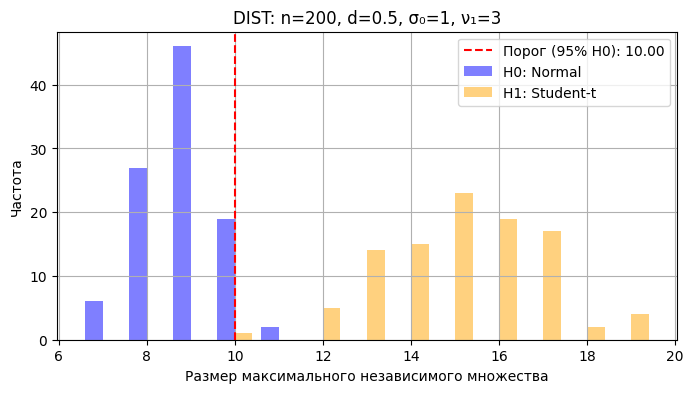

Power (H1): 0.990

=== DIST: n=200, d=1.0, σ₀=1, ν₁=3 ===


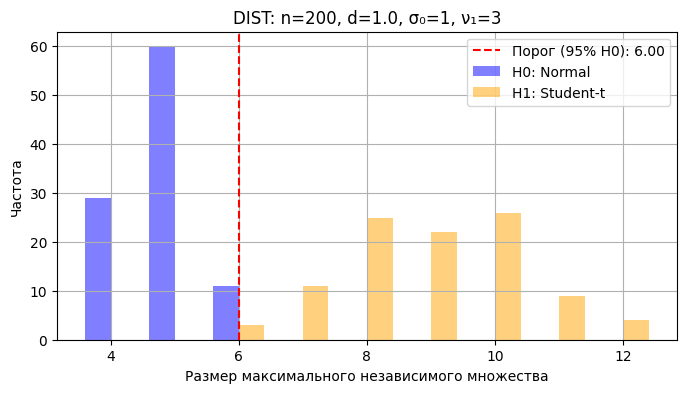

Power (H1): 0.970

=== KNN: n=500, k=2, σ₀=1, ν₁=3 ===


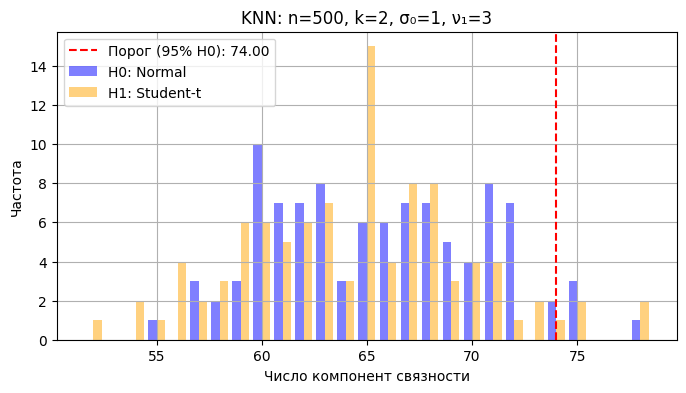

Power (H1): 0.040

=== KNN: n=500, k=3, σ₀=1, ν₁=3 ===


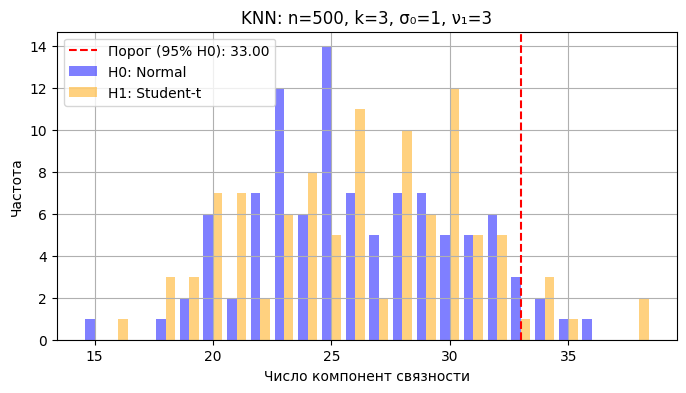

Power (H1): 0.060

=== KNN: n=500, k=4, σ₀=1, ν₁=3 ===


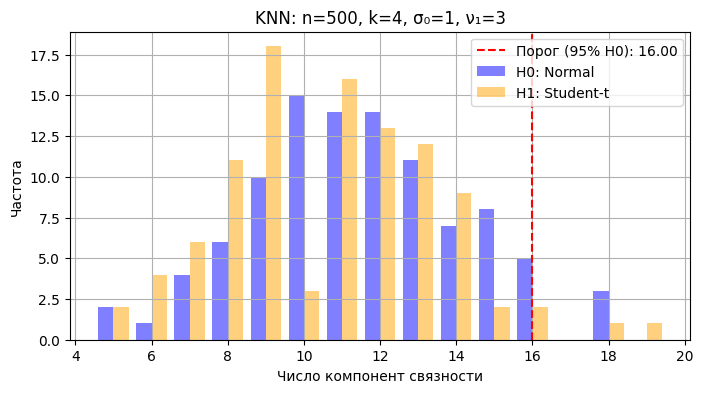

Power (H1): 0.020

=== KNN: n=500, k=5, σ₀=1, ν₁=3 ===


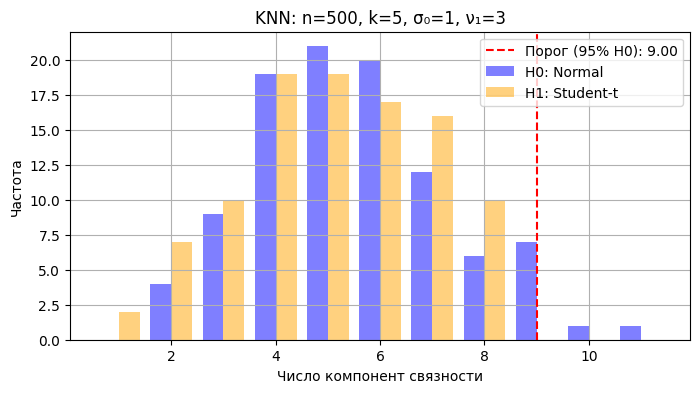

Power (H1): 0.000

=== KNN: n=500, k=10, σ₀=1, ν₁=3 ===


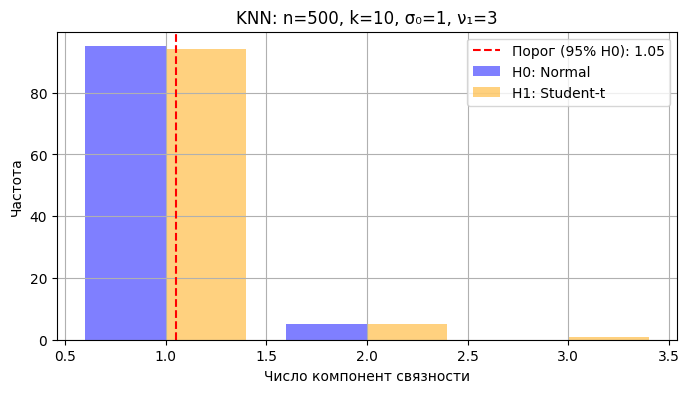

Power (H1): 0.060

=== KNN: n=500, k=20, σ₀=1, ν₁=3 ===


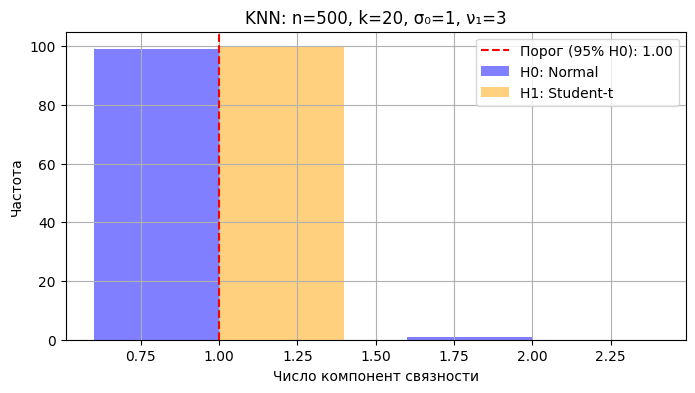

Power (H1): 0.000

=== KNN: n=500, k=40, σ₀=1, ν₁=3 ===


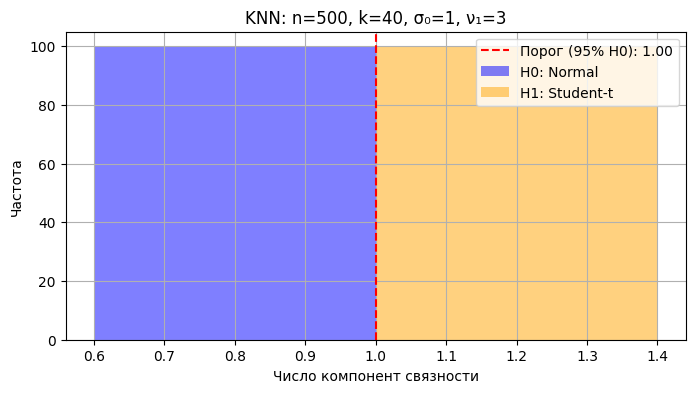

Power (H1): 0.000

=== KNN: n=500, k=80, σ₀=1, ν₁=3 ===


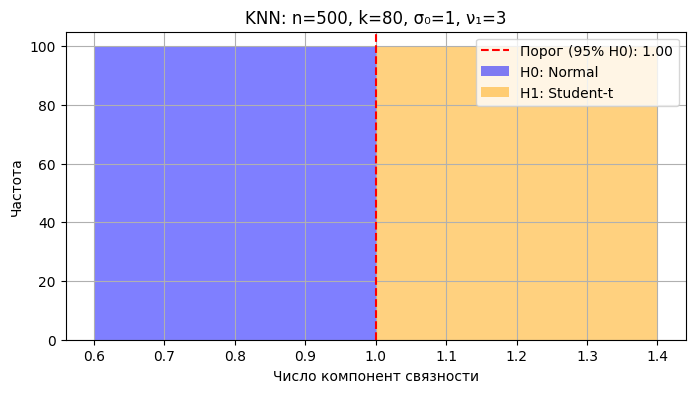

Power (H1): 0.000

=== DIST: n=500, d=0.1, σ₀=1, ν₁=3 ===


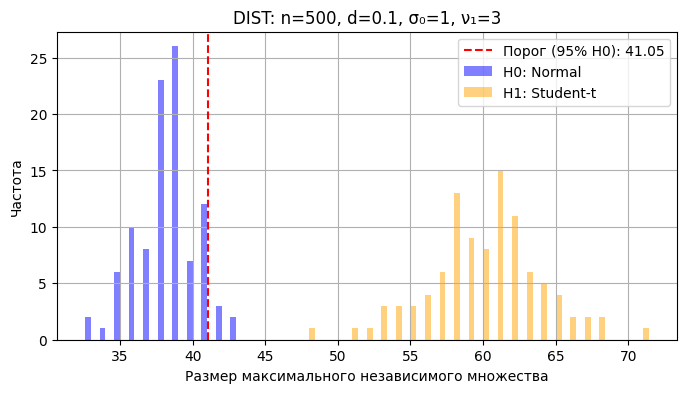

Power (H1): 1.000

=== DIST: n=500, d=0.2, σ₀=1, ν₁=3 ===


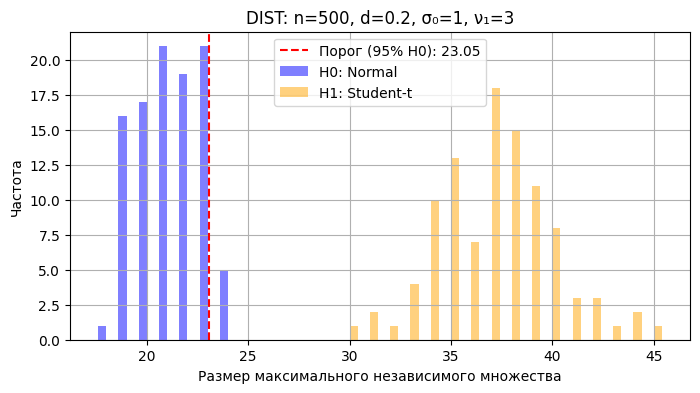

Power (H1): 1.000

=== DIST: n=500, d=0.5, σ₀=1, ν₁=3 ===


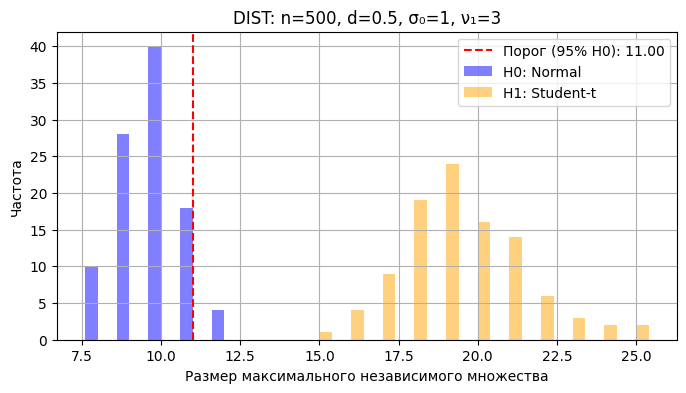

Power (H1): 1.000

=== DIST: n=500, d=1.0, σ₀=1, ν₁=3 ===


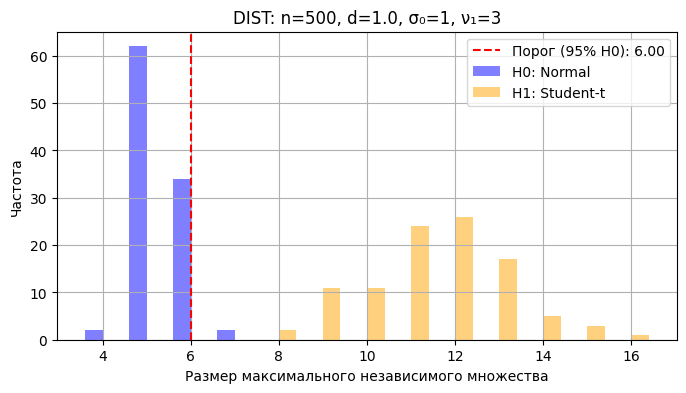

Power (H1): 1.000



In [9]:
n_values = [100, 200, 500]
k_values = [2, 3, 4, 5, 10, 20, 40, 80]
d_values = [0.1, 0.2, 0.5, 1.0]
sigma_values = [1]
nu_values = [3]

import seaborn as sns
import matplotlib.pyplot as plt

df_results = perebiralka(n_values, k_values, d_values, sigma_values, nu_values, n_sim=100)





- выведем тепловые карты чтобы лучше проанализировать происходящее

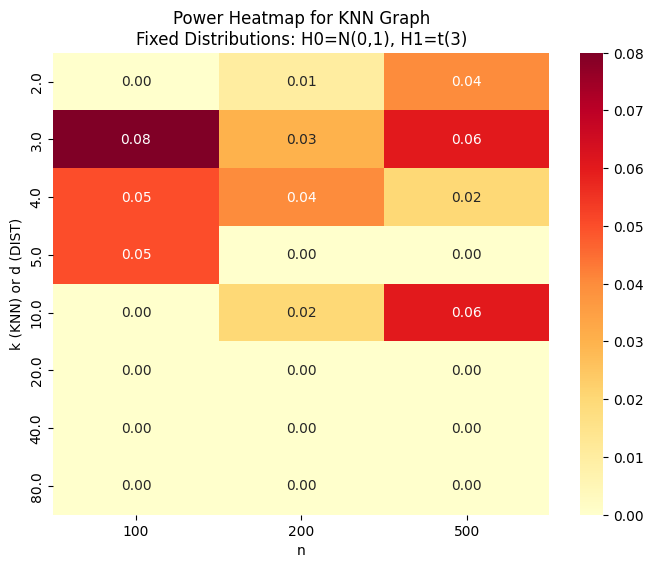

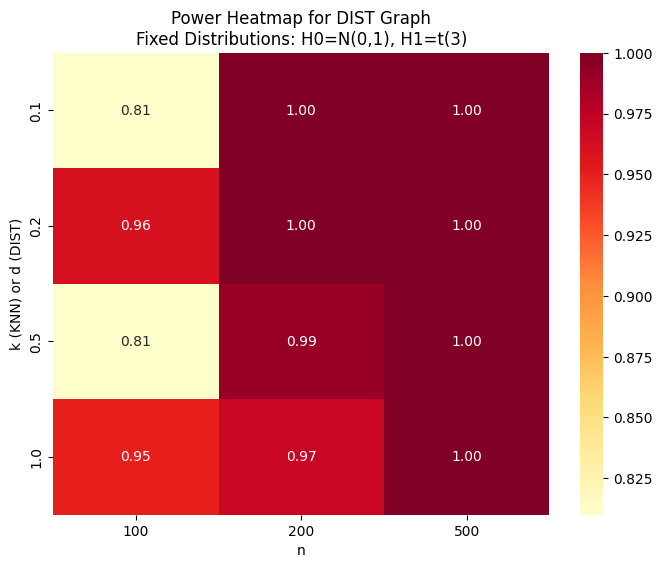

In [10]:
def plot_power_heatmap_fixed(df, graph_type):
    df_plot = df[df['Graph'] == graph_type]
    pivot_power = df_plot.pivot(index='k/d', columns='n', values='Power (H1)')
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_power, annot=True, cmap='YlOrRd', fmt=".2f")
    plt.title(f'Power Heatmap for {graph_type} Graph\nFixed Distributions: H0=N(0,1), H1=t(3)')
    plt.xlabel('n')
    plt.ylabel('k (KNN) or d (DIST)')
    plt.show()

# Для KNN:
plot_power_heatmap_fixed(df_results, 'KNN')

# Для DIST:
plot_power_heatmap_fixed(df_results, 'DIST')

## Выводы

- для KNN графа к сожалению мало что получилось. при разных параметрах размера выборки и числа рассматриваемых соседей нигде не получается провести качественную границу, Power стабильно ниже даже 0.1, данные очень сильно смешались
- для DIST графа все очень даже хорошо, при немалой выборке (более 100) при всех рассмотренных значениях D power не менее 0.99, это говорит о том, что характеристика размер максимального независимого множества отлично работает

## Исследуем параметры распределений при фиксированных n = 200, k = 4, d = 0.2

=== KNN: n=200, k=4, σ₀=0.2, ν₁=1.5 ===


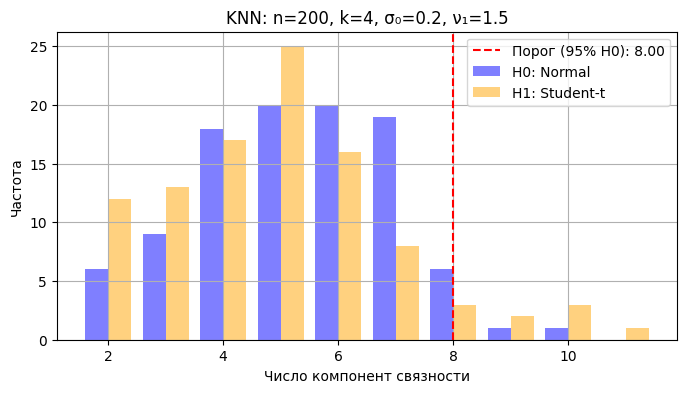

Power (H1): 0.060

=== DIST: n=200, d=0.2, σ₀=0.2, ν₁=1.5 ===


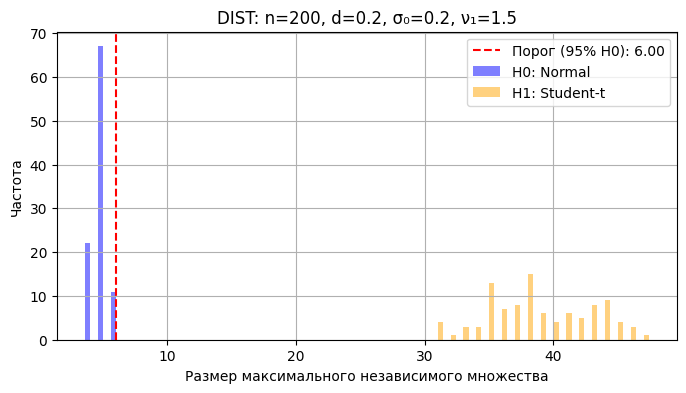

Power (H1): 1.000

=== KNN: n=200, k=4, σ₀=0.2, ν₁=2 ===


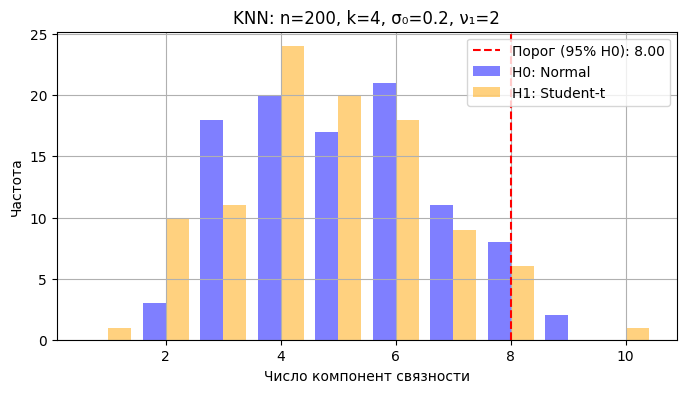

Power (H1): 0.010

=== DIST: n=200, d=0.2, σ₀=0.2, ν₁=2 ===


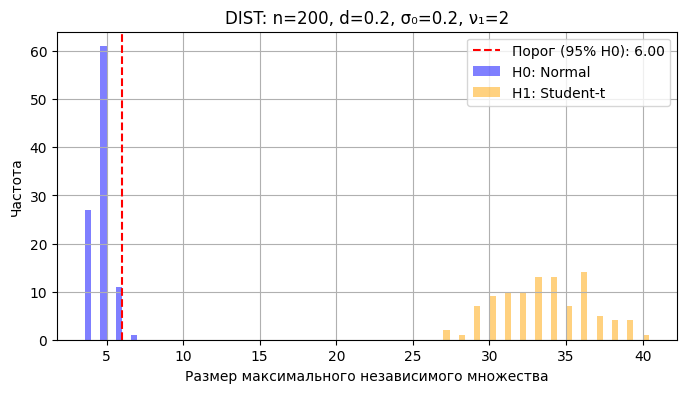

Power (H1): 1.000

=== KNN: n=200, k=4, σ₀=0.2, ν₁=3 ===


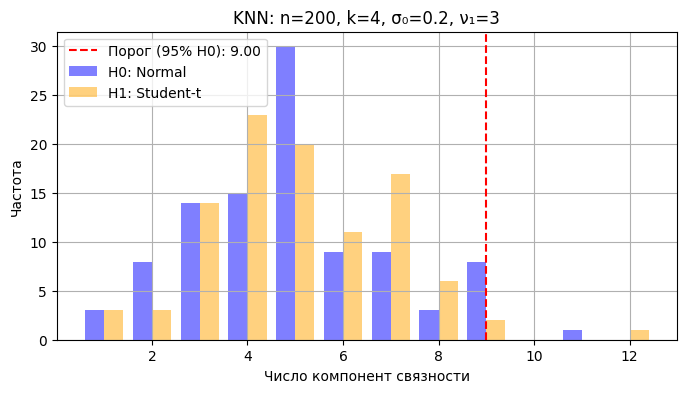

Power (H1): 0.010

=== DIST: n=200, d=0.2, σ₀=0.2, ν₁=3 ===


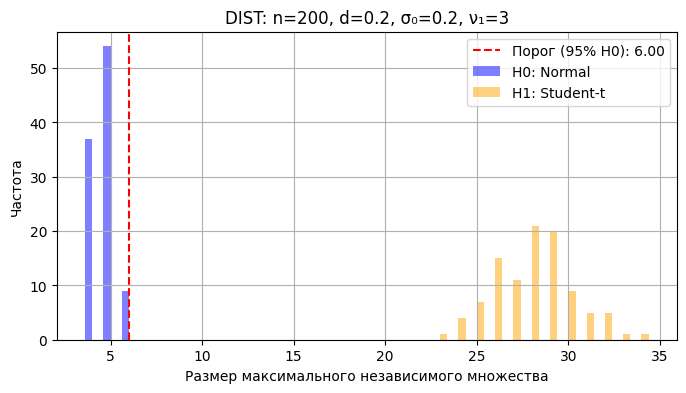

Power (H1): 1.000

=== KNN: n=200, k=4, σ₀=0.2, ν₁=5 ===


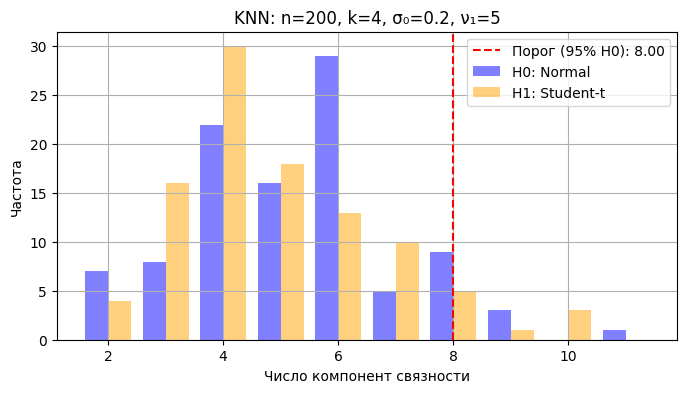

Power (H1): 0.040

=== DIST: n=200, d=0.2, σ₀=0.2, ν₁=5 ===


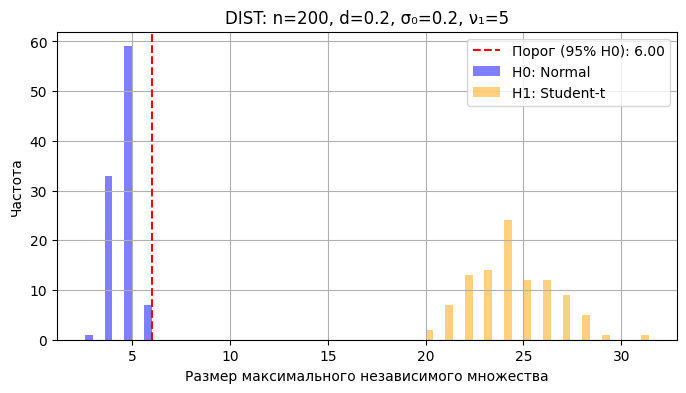

Power (H1): 1.000

=== KNN: n=200, k=4, σ₀=0.2, ν₁=10 ===


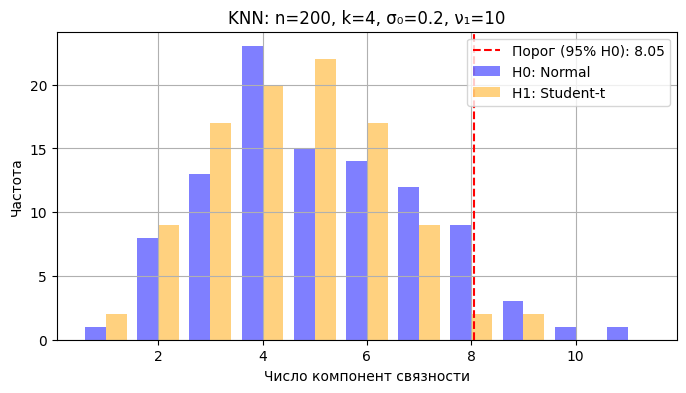

Power (H1): 0.020

=== DIST: n=200, d=0.2, σ₀=0.2, ν₁=10 ===


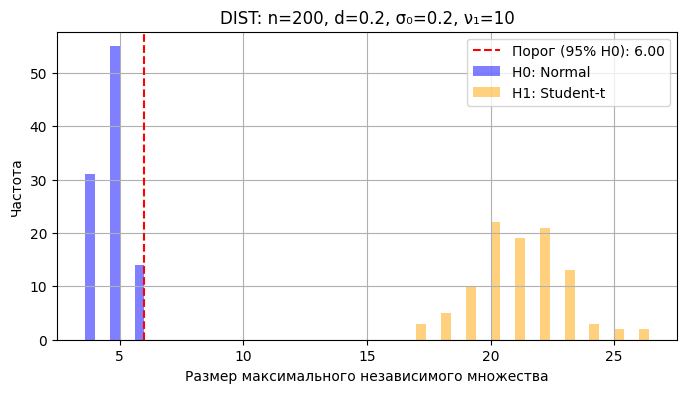

Power (H1): 1.000

=== KNN: n=200, k=4, σ₀=0.2, ν₁=20 ===


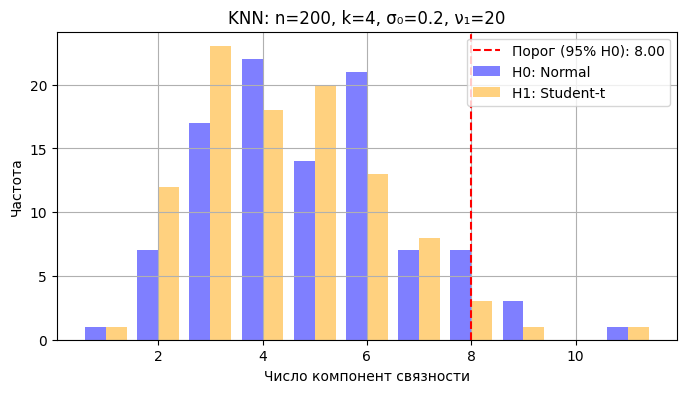

Power (H1): 0.020

=== DIST: n=200, d=0.2, σ₀=0.2, ν₁=20 ===


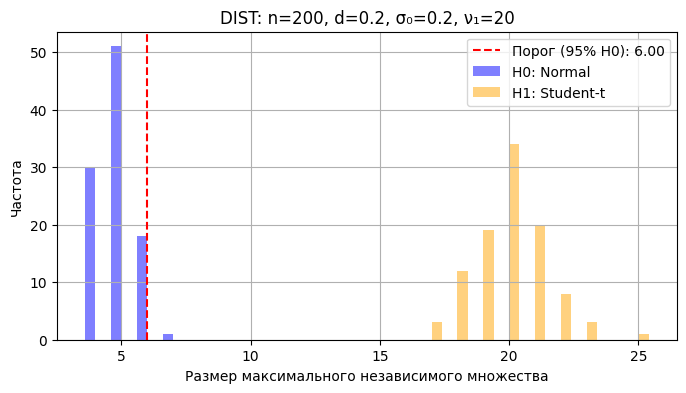

Power (H1): 1.000

=== KNN: n=200, k=4, σ₀=0.5, ν₁=1.5 ===


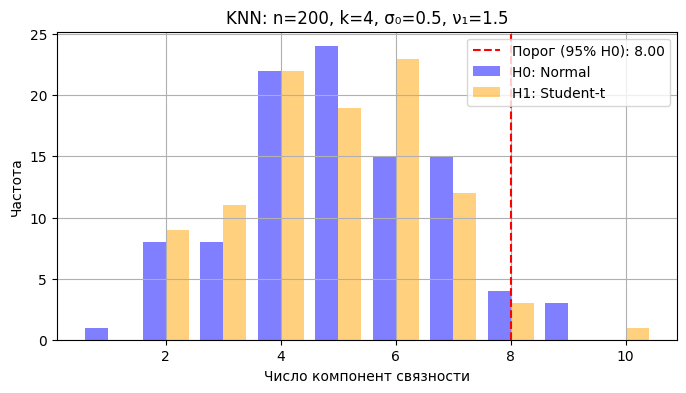

Power (H1): 0.010

=== DIST: n=200, d=0.2, σ₀=0.5, ν₁=1.5 ===


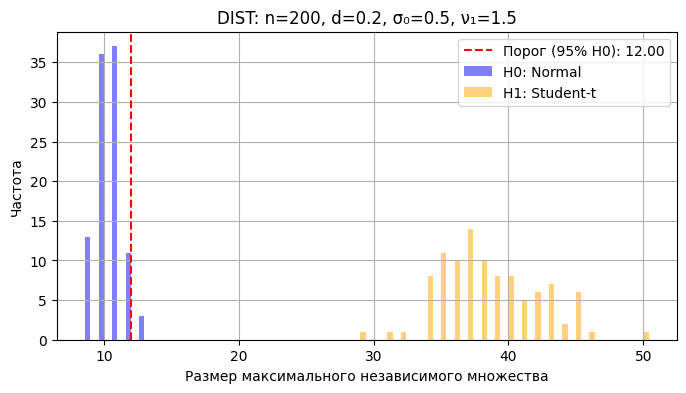

Power (H1): 1.000

=== KNN: n=200, k=4, σ₀=0.5, ν₁=2 ===


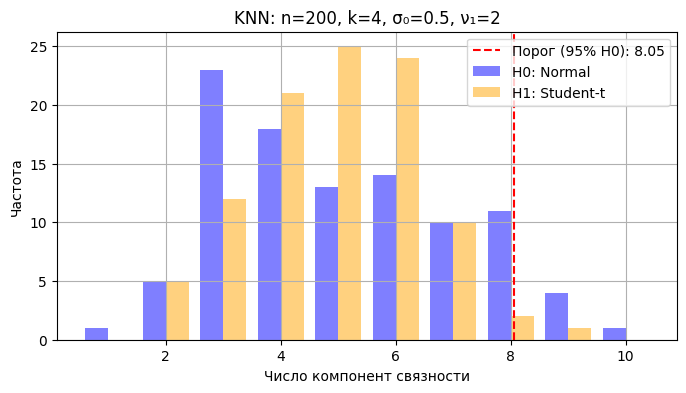

Power (H1): 0.010

=== DIST: n=200, d=0.2, σ₀=0.5, ν₁=2 ===


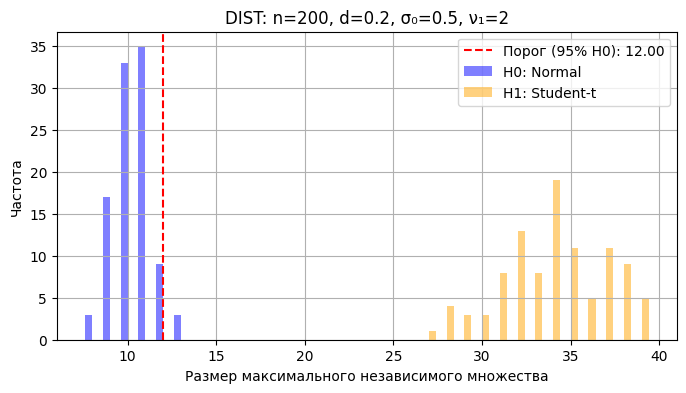

Power (H1): 1.000

=== KNN: n=200, k=4, σ₀=0.5, ν₁=3 ===


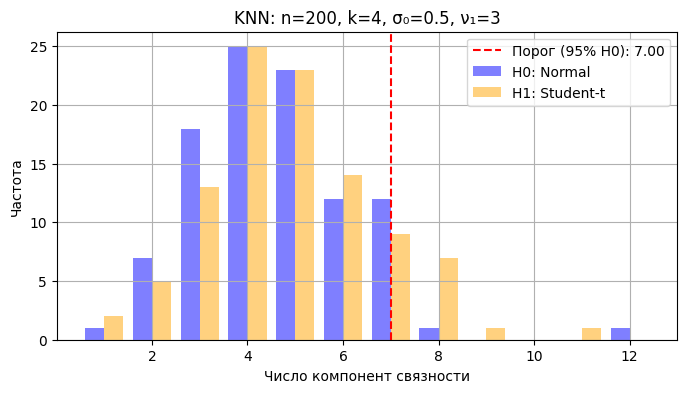

Power (H1): 0.090

=== DIST: n=200, d=0.2, σ₀=0.5, ν₁=3 ===


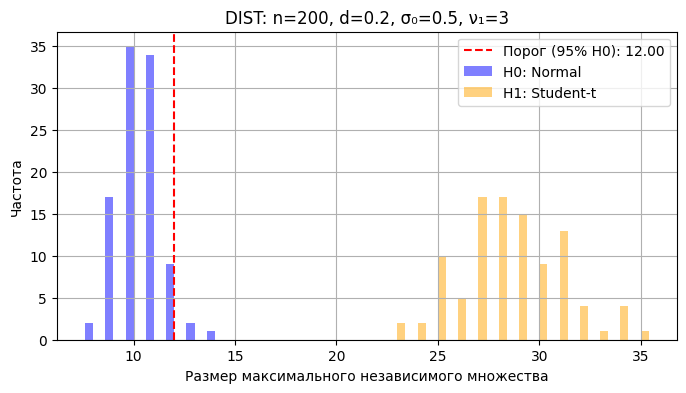

Power (H1): 1.000

=== KNN: n=200, k=4, σ₀=0.5, ν₁=5 ===


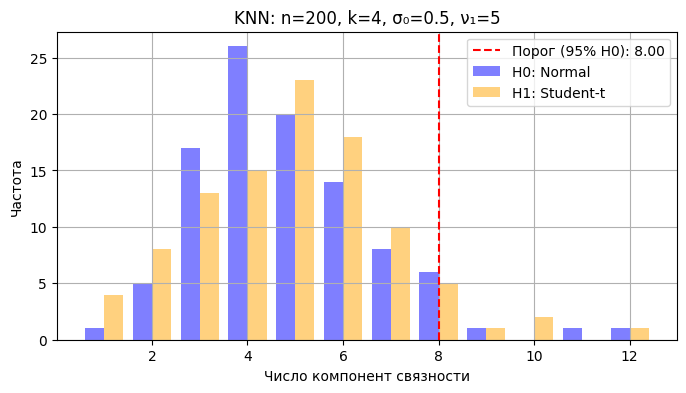

Power (H1): 0.040

=== DIST: n=200, d=0.2, σ₀=0.5, ν₁=5 ===


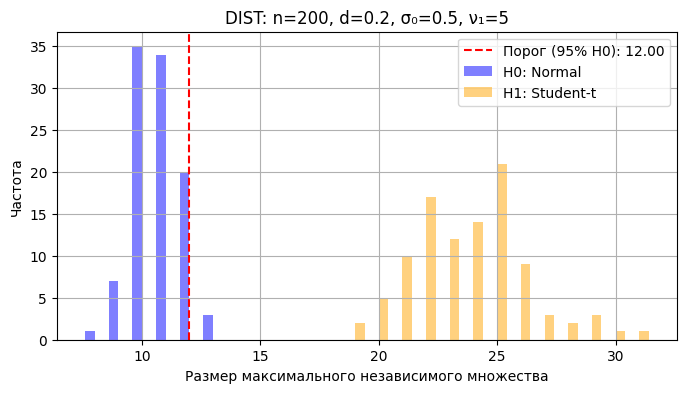

Power (H1): 1.000

=== KNN: n=200, k=4, σ₀=0.5, ν₁=10 ===


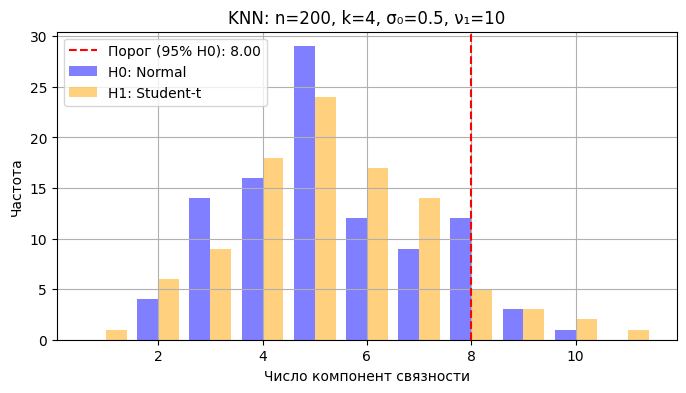

Power (H1): 0.060

=== DIST: n=200, d=0.2, σ₀=0.5, ν₁=10 ===


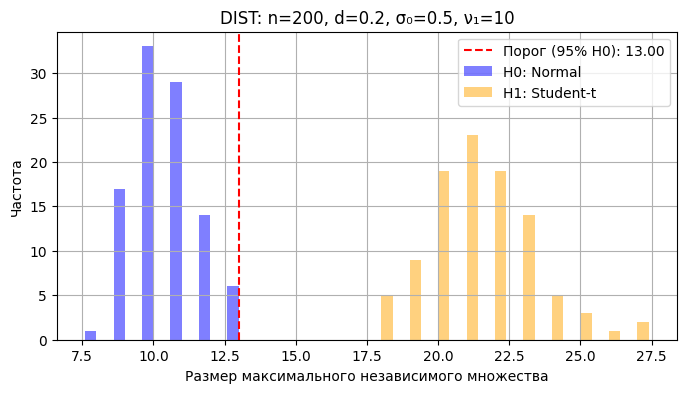

Power (H1): 1.000

=== KNN: n=200, k=4, σ₀=0.5, ν₁=20 ===


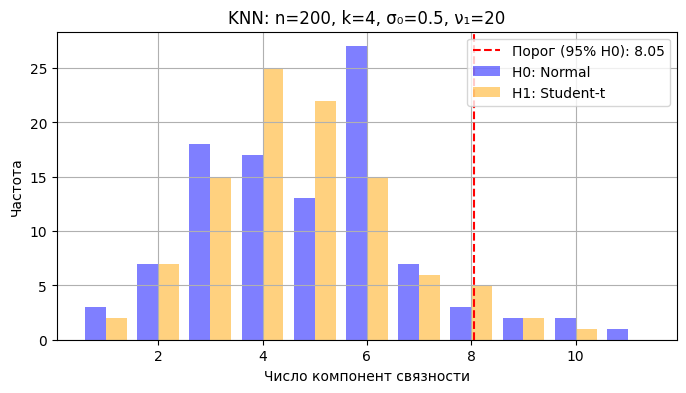

Power (H1): 0.030

=== DIST: n=200, d=0.2, σ₀=0.5, ν₁=20 ===


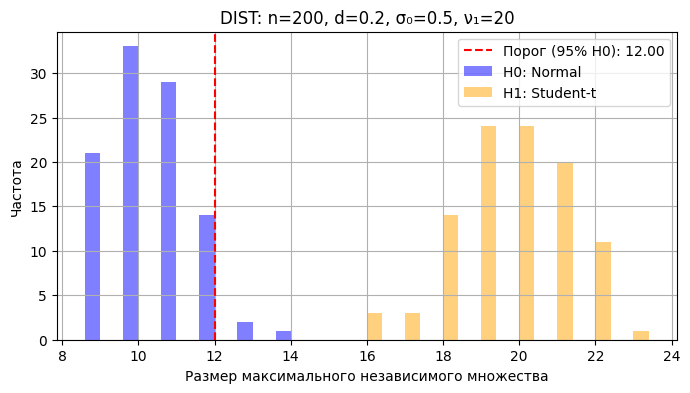

Power (H1): 1.000

=== KNN: n=200, k=4, σ₀=0.7, ν₁=1.5 ===


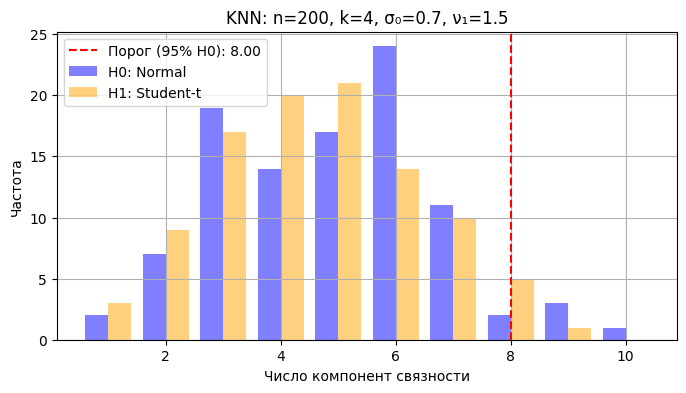

Power (H1): 0.010

=== DIST: n=200, d=0.2, σ₀=0.7, ν₁=1.5 ===


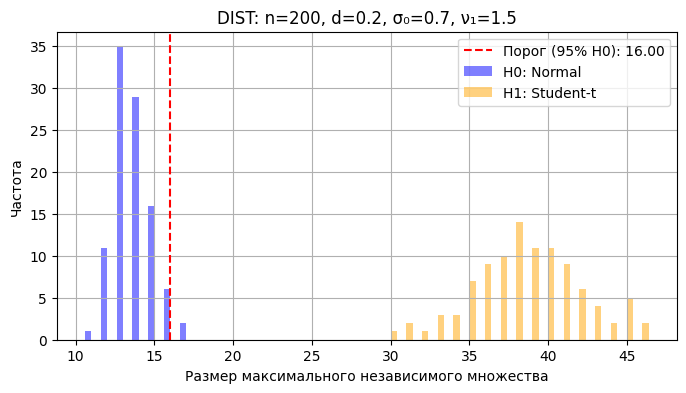

Power (H1): 1.000

=== KNN: n=200, k=4, σ₀=0.7, ν₁=2 ===


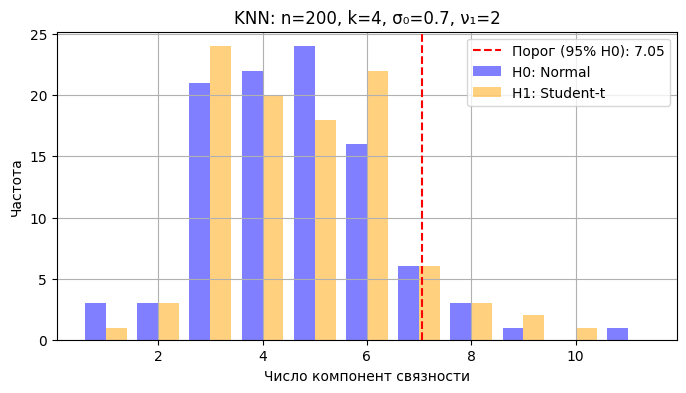

Power (H1): 0.060

=== DIST: n=200, d=0.2, σ₀=0.7, ν₁=2 ===


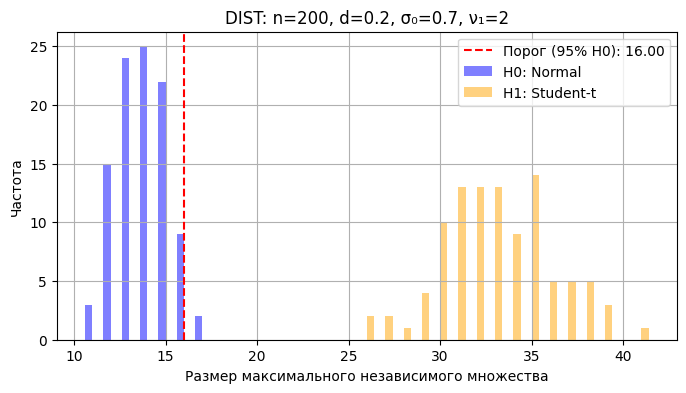

Power (H1): 1.000

=== KNN: n=200, k=4, σ₀=0.7, ν₁=3 ===


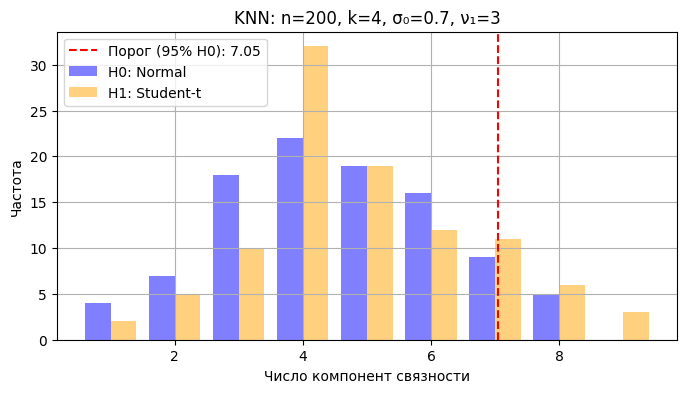

Power (H1): 0.090

=== DIST: n=200, d=0.2, σ₀=0.7, ν₁=3 ===


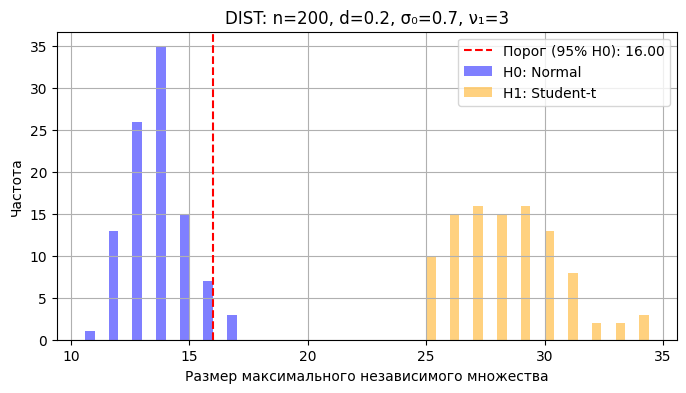

Power (H1): 1.000

=== KNN: n=200, k=4, σ₀=0.7, ν₁=5 ===


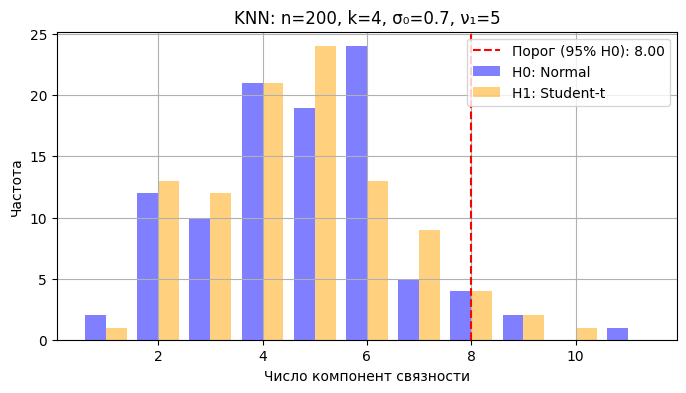

Power (H1): 0.030

=== DIST: n=200, d=0.2, σ₀=0.7, ν₁=5 ===


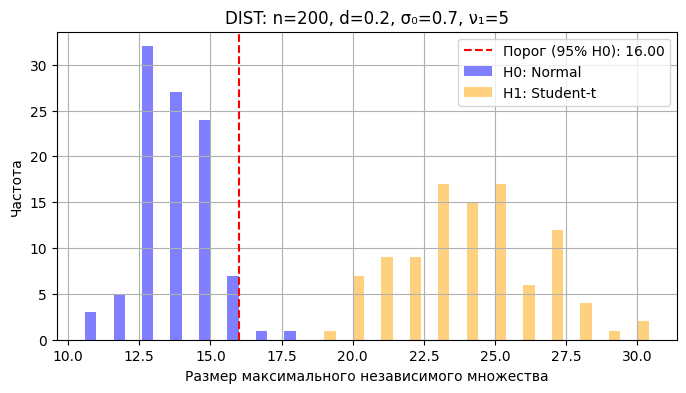

Power (H1): 1.000

=== KNN: n=200, k=4, σ₀=0.7, ν₁=10 ===


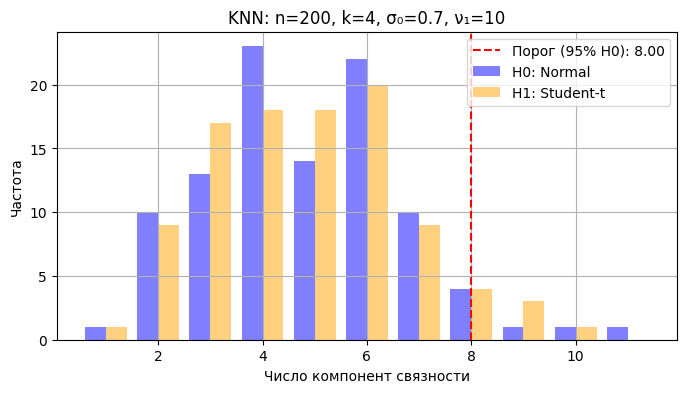

Power (H1): 0.040

=== DIST: n=200, d=0.2, σ₀=0.7, ν₁=10 ===


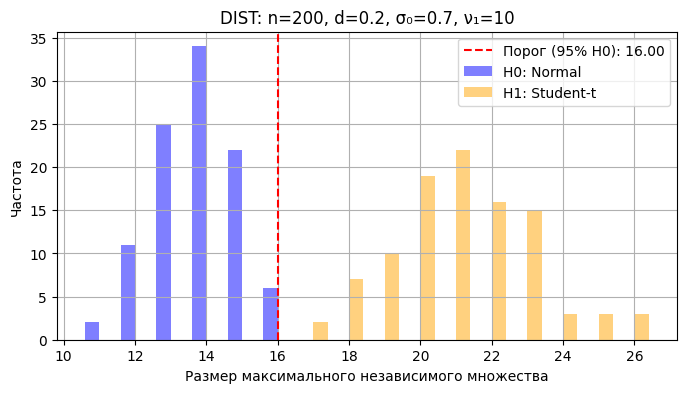

Power (H1): 1.000

=== KNN: n=200, k=4, σ₀=0.7, ν₁=20 ===


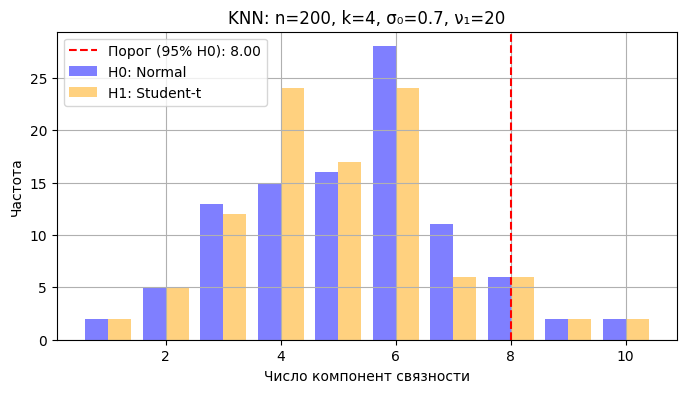

Power (H1): 0.040

=== DIST: n=200, d=0.2, σ₀=0.7, ν₁=20 ===


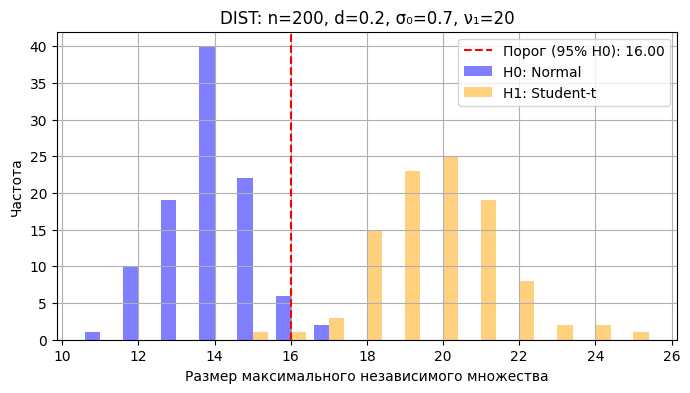

Power (H1): 0.980

=== KNN: n=200, k=4, σ₀=1, ν₁=1.5 ===


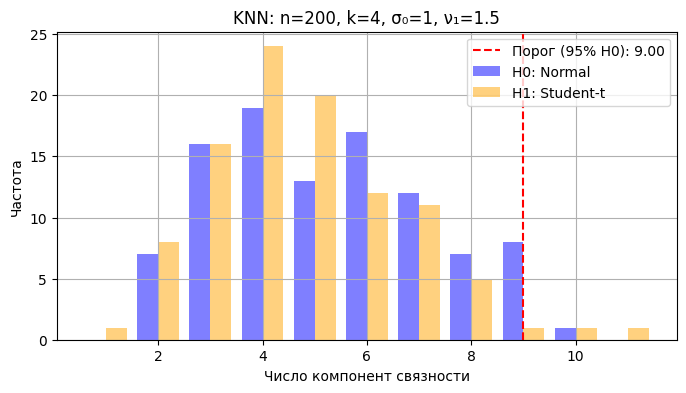

Power (H1): 0.020

=== DIST: n=200, d=0.2, σ₀=1, ν₁=1.5 ===


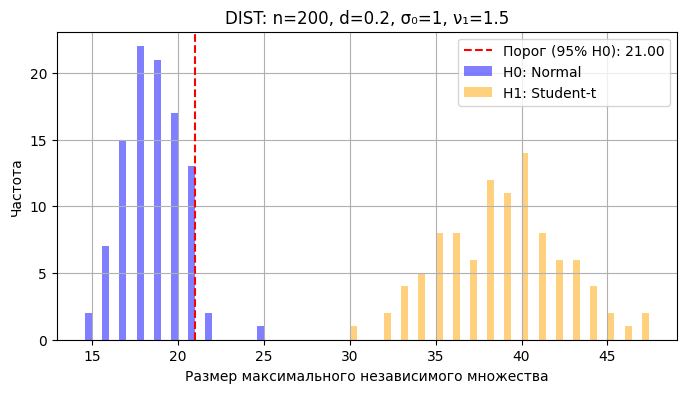

Power (H1): 1.000

=== KNN: n=200, k=4, σ₀=1, ν₁=2 ===


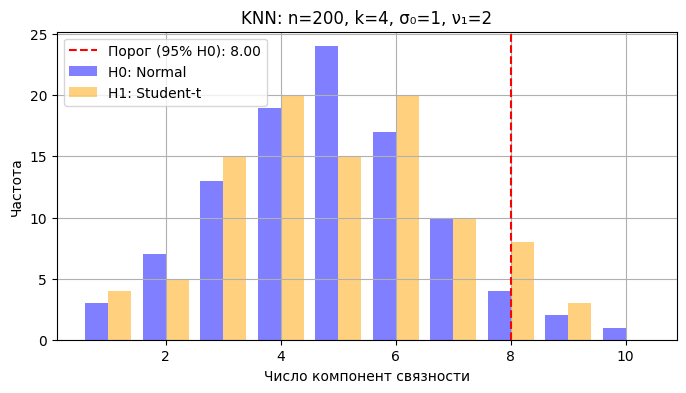

Power (H1): 0.030

=== DIST: n=200, d=0.2, σ₀=1, ν₁=2 ===


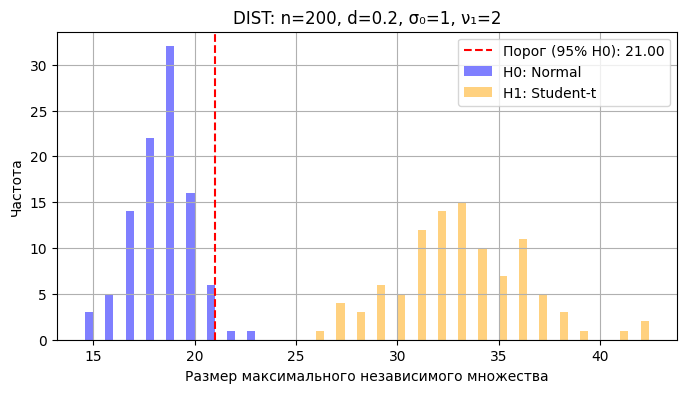

Power (H1): 1.000

=== KNN: n=200, k=4, σ₀=1, ν₁=3 ===


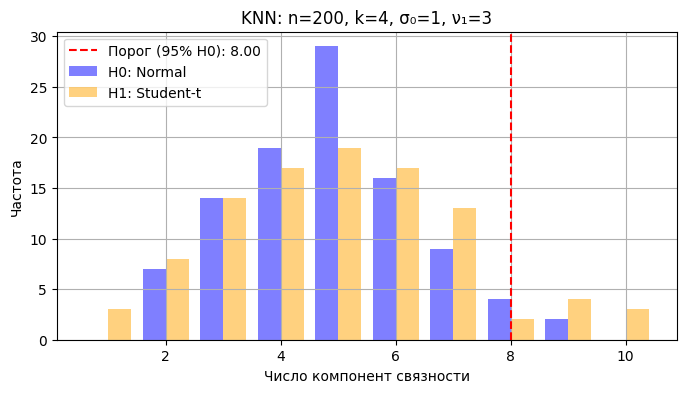

Power (H1): 0.070

=== DIST: n=200, d=0.2, σ₀=1, ν₁=3 ===


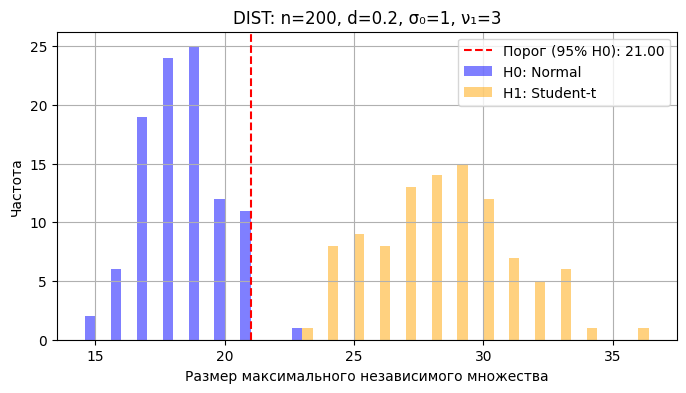

Power (H1): 1.000

=== KNN: n=200, k=4, σ₀=1, ν₁=5 ===


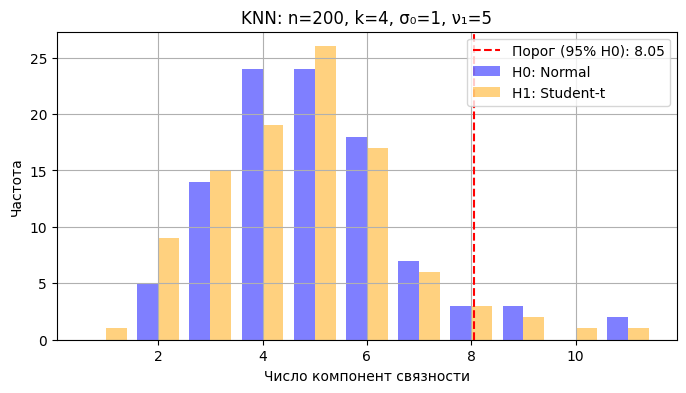

Power (H1): 0.040

=== DIST: n=200, d=0.2, σ₀=1, ν₁=5 ===


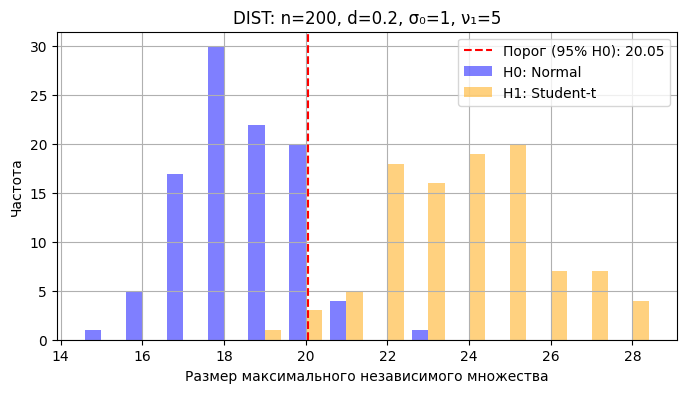

Power (H1): 0.960

=== KNN: n=200, k=4, σ₀=1, ν₁=10 ===


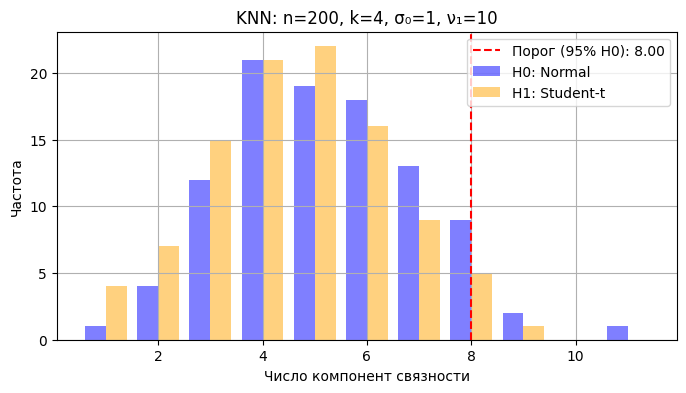

Power (H1): 0.010

=== DIST: n=200, d=0.2, σ₀=1, ν₁=10 ===


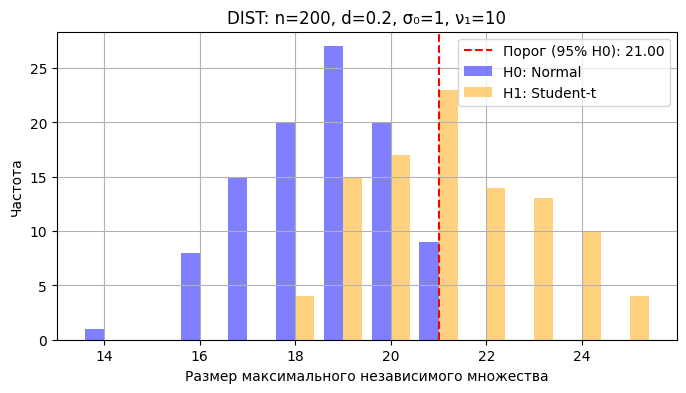

Power (H1): 0.410

=== KNN: n=200, k=4, σ₀=1, ν₁=20 ===


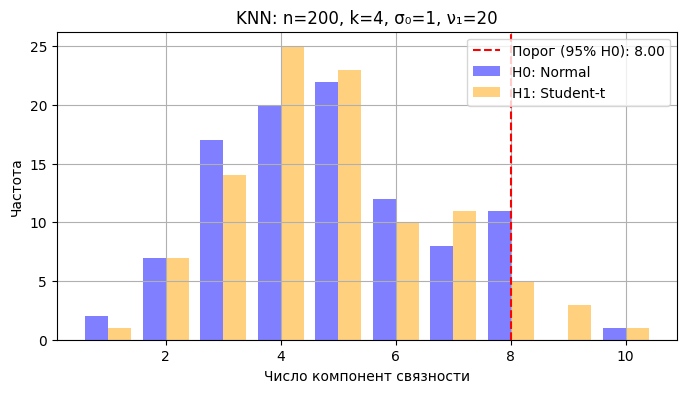

Power (H1): 0.040

=== DIST: n=200, d=0.2, σ₀=1, ν₁=20 ===


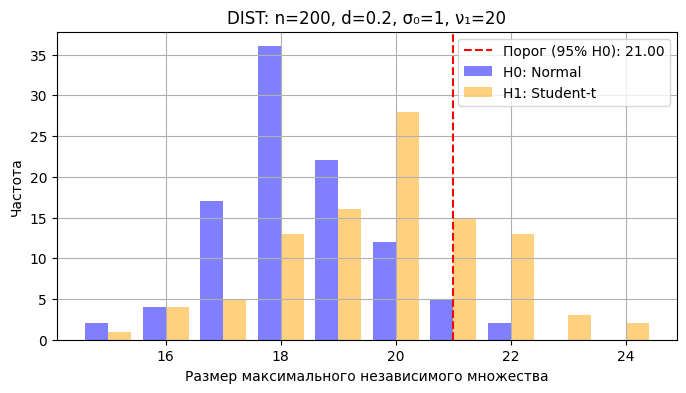

Power (H1): 0.180

=== KNN: n=200, k=4, σ₀=1.5, ν₁=1.5 ===


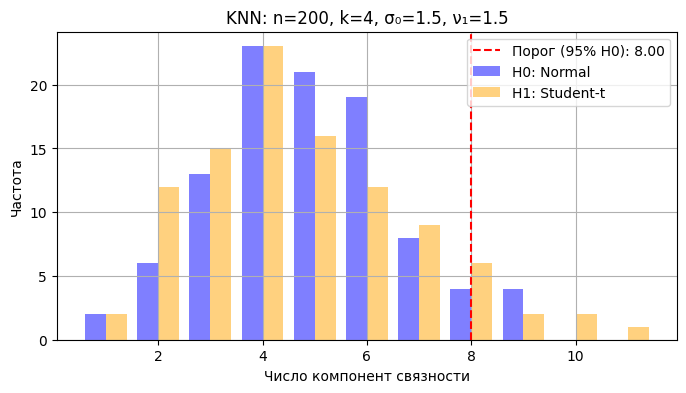

Power (H1): 0.050

=== DIST: n=200, d=0.2, σ₀=1.5, ν₁=1.5 ===


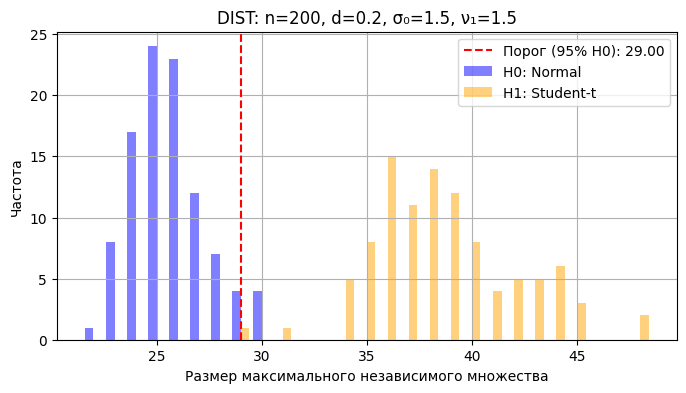

Power (H1): 0.990

=== KNN: n=200, k=4, σ₀=1.5, ν₁=2 ===


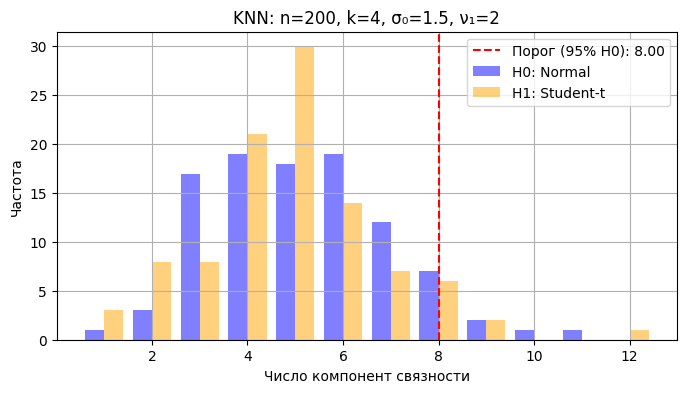

Power (H1): 0.030

=== DIST: n=200, d=0.2, σ₀=1.5, ν₁=2 ===


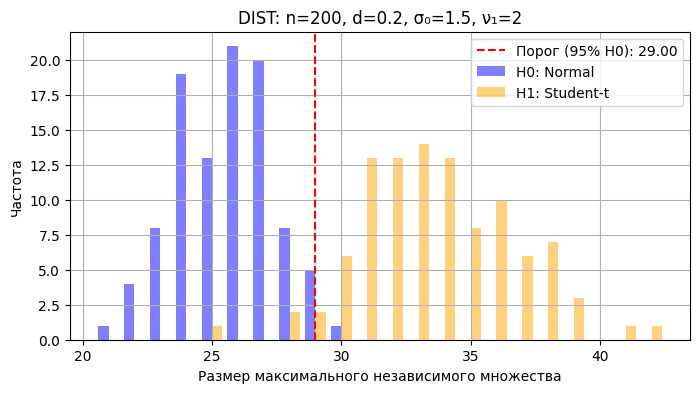

Power (H1): 0.950

=== KNN: n=200, k=4, σ₀=1.5, ν₁=3 ===


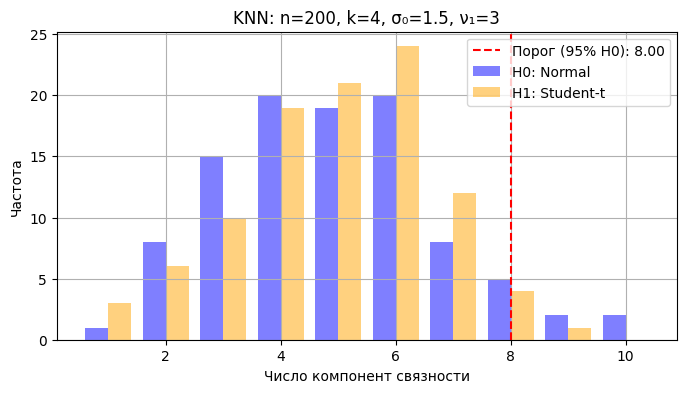

Power (H1): 0.010

=== DIST: n=200, d=0.2, σ₀=1.5, ν₁=3 ===


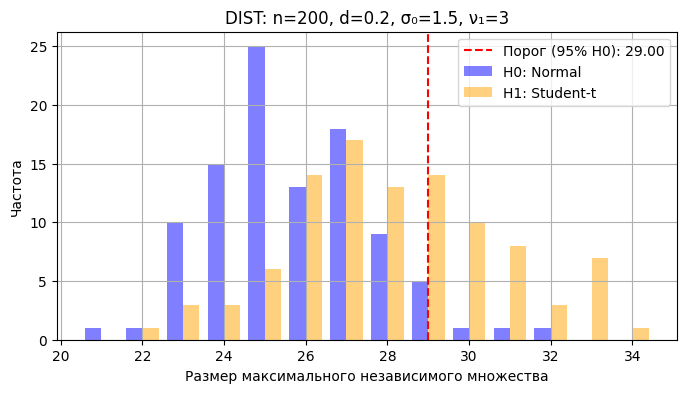

Power (H1): 0.290

=== KNN: n=200, k=4, σ₀=1.5, ν₁=5 ===


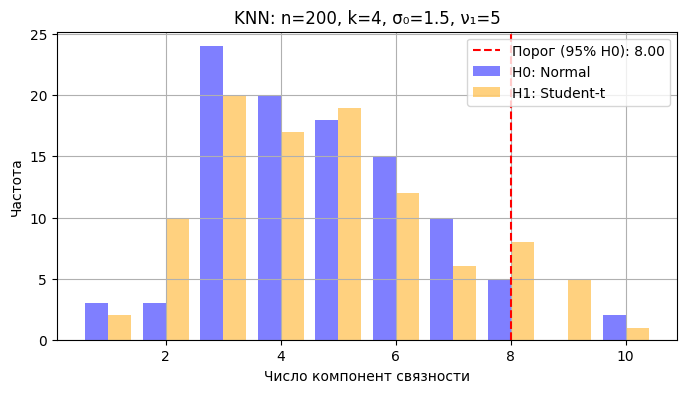

Power (H1): 0.060

=== DIST: n=200, d=0.2, σ₀=1.5, ν₁=5 ===


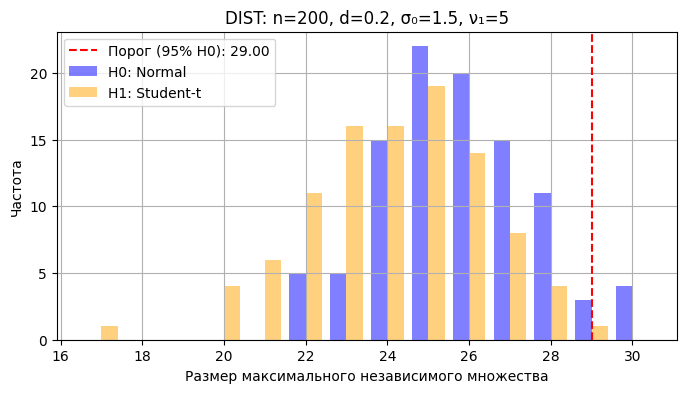

Power (H1): 0.000

=== KNN: n=200, k=4, σ₀=1.5, ν₁=10 ===


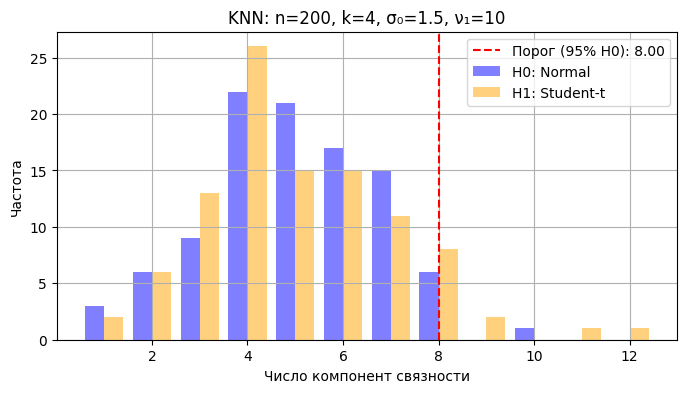

Power (H1): 0.040

=== DIST: n=200, d=0.2, σ₀=1.5, ν₁=10 ===


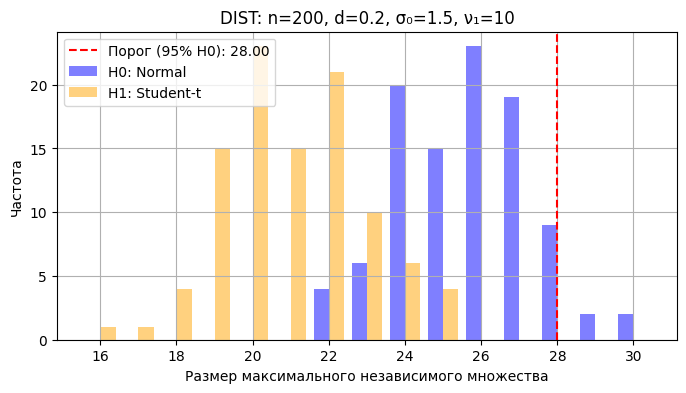

Power (H1): 0.000

=== KNN: n=200, k=4, σ₀=1.5, ν₁=20 ===


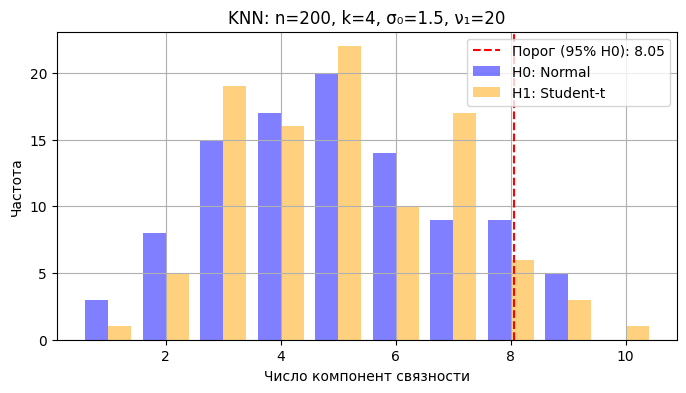

Power (H1): 0.040

=== DIST: n=200, d=0.2, σ₀=1.5, ν₁=20 ===


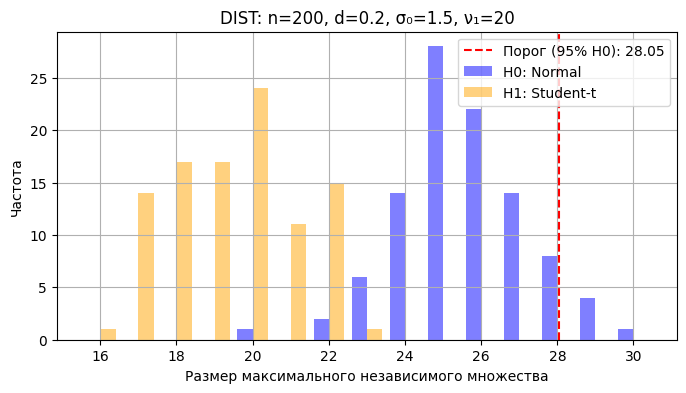

Power (H1): 0.000

=== KNN: n=200, k=4, σ₀=2, ν₁=1.5 ===


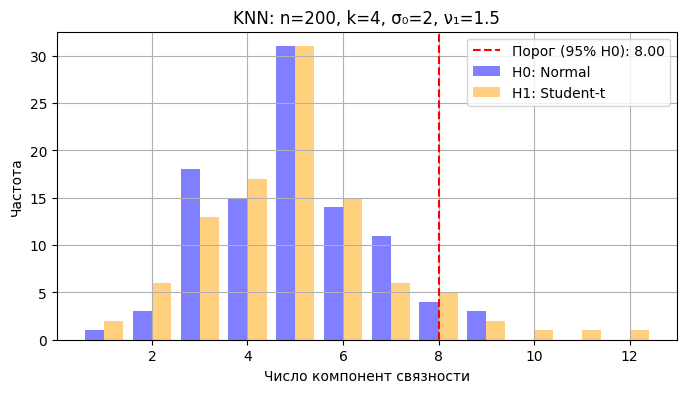

Power (H1): 0.050

=== DIST: n=200, d=0.2, σ₀=2, ν₁=1.5 ===


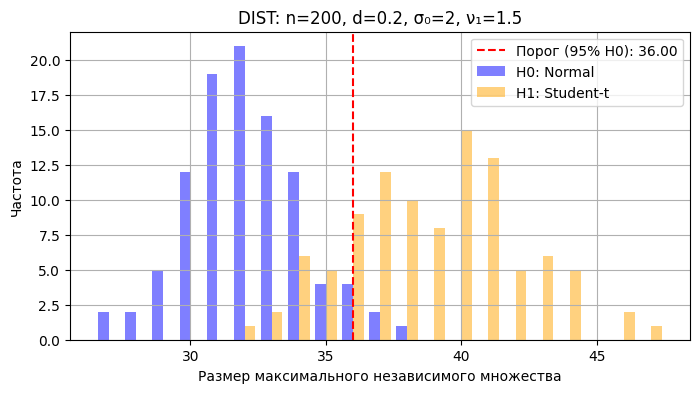

Power (H1): 0.770

=== KNN: n=200, k=4, σ₀=2, ν₁=2 ===


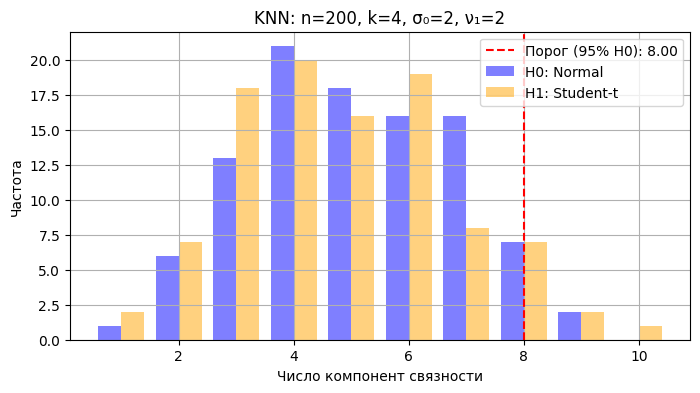

Power (H1): 0.030

=== DIST: n=200, d=0.2, σ₀=2, ν₁=2 ===


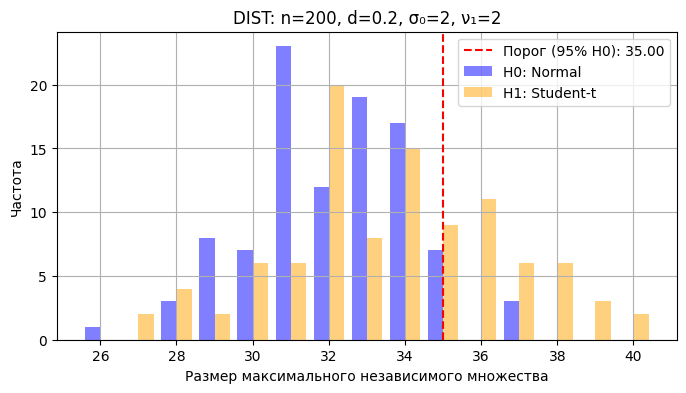

Power (H1): 0.280

=== KNN: n=200, k=4, σ₀=2, ν₁=3 ===


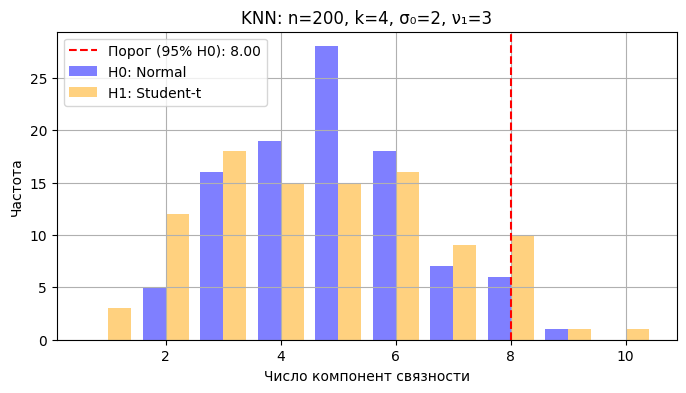

Power (H1): 0.020

=== DIST: n=200, d=0.2, σ₀=2, ν₁=3 ===


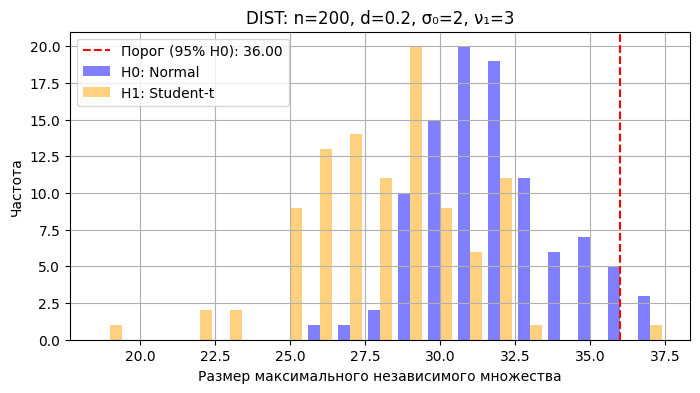

Power (H1): 0.010

=== KNN: n=200, k=4, σ₀=2, ν₁=5 ===


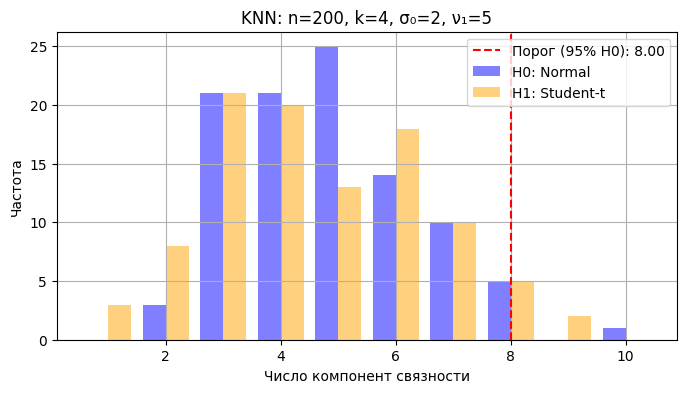

Power (H1): 0.020

=== DIST: n=200, d=0.2, σ₀=2, ν₁=5 ===


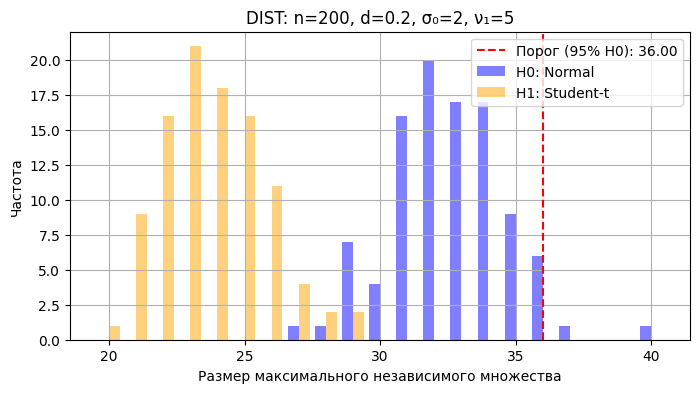

Power (H1): 0.000

=== KNN: n=200, k=4, σ₀=2, ν₁=10 ===


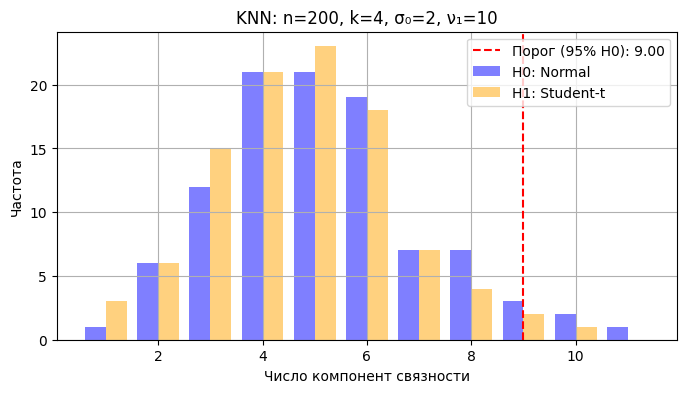

Power (H1): 0.010

=== DIST: n=200, d=0.2, σ₀=2, ν₁=10 ===


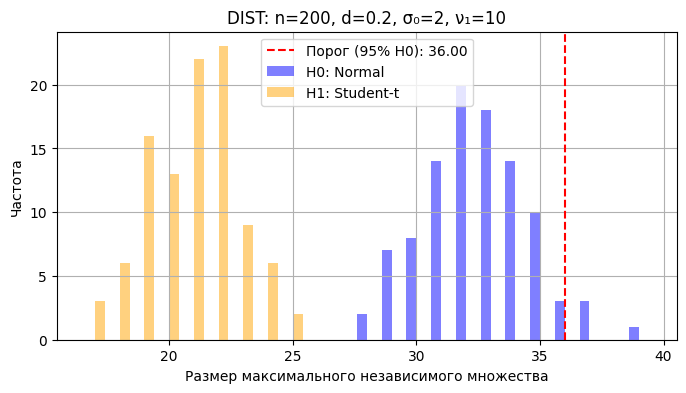

Power (H1): 0.000

=== KNN: n=200, k=4, σ₀=2, ν₁=20 ===


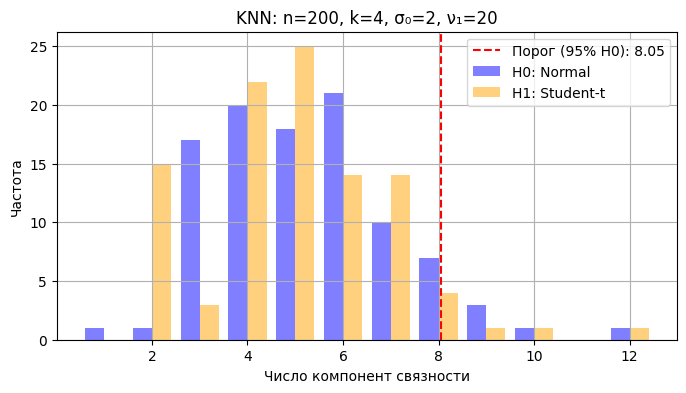

Power (H1): 0.030

=== DIST: n=200, d=0.2, σ₀=2, ν₁=20 ===


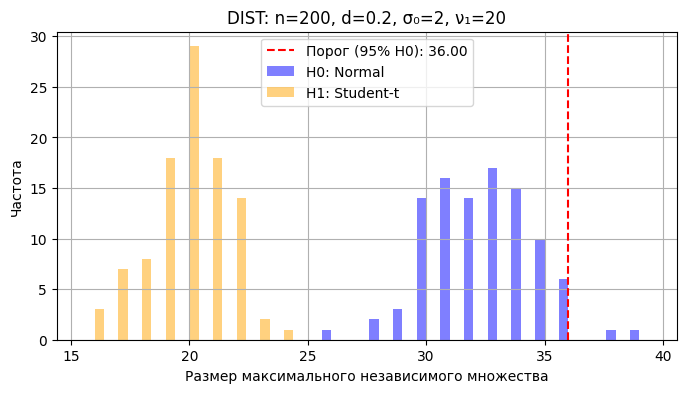

Power (H1): 0.000

=== KNN: n=200, k=4, σ₀=3, ν₁=1.5 ===


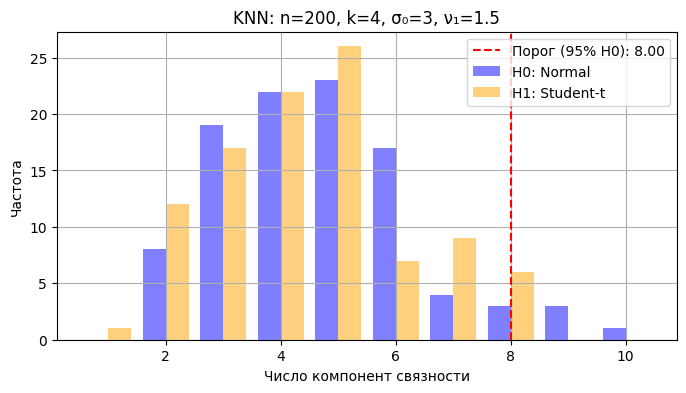

Power (H1): 0.000

=== DIST: n=200, d=0.2, σ₀=3, ν₁=1.5 ===


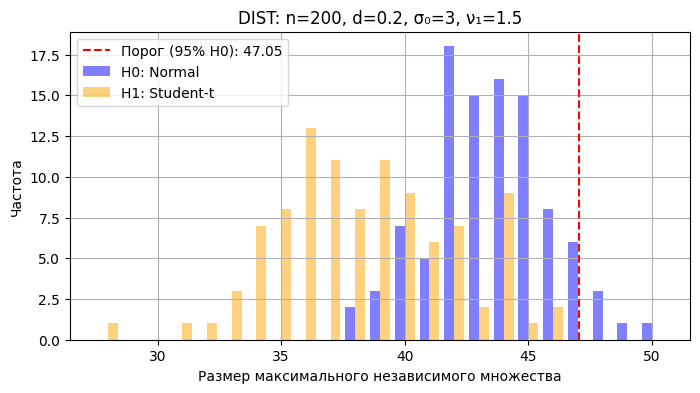

Power (H1): 0.000

=== KNN: n=200, k=4, σ₀=3, ν₁=2 ===


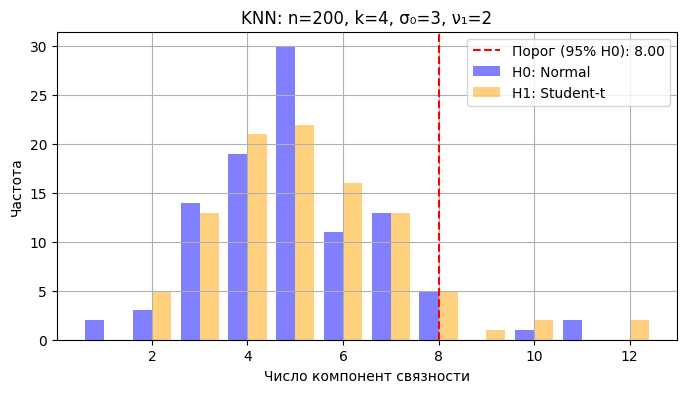

Power (H1): 0.050

=== DIST: n=200, d=0.2, σ₀=3, ν₁=2 ===


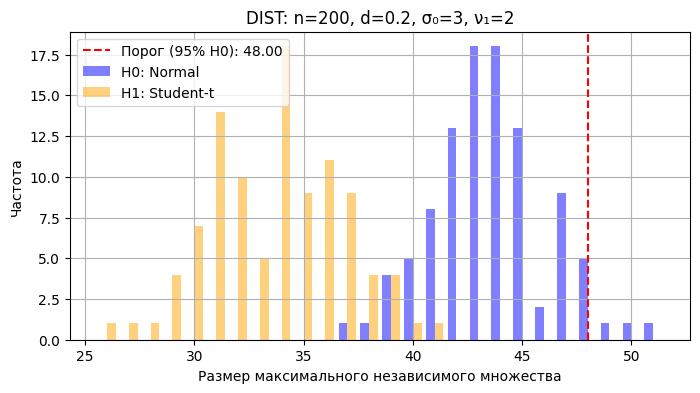

Power (H1): 0.000

=== KNN: n=200, k=4, σ₀=3, ν₁=3 ===


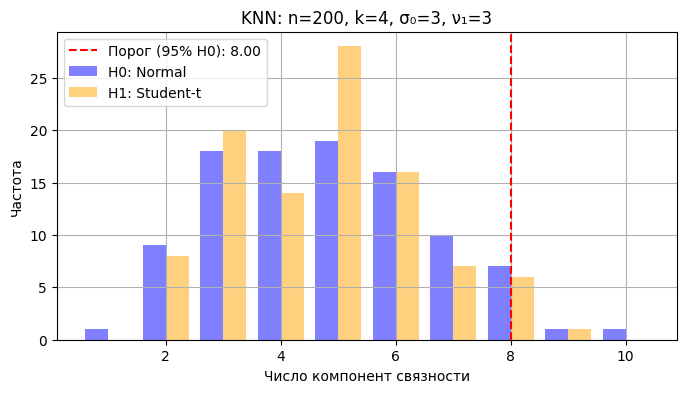

Power (H1): 0.010

=== DIST: n=200, d=0.2, σ₀=3, ν₁=3 ===


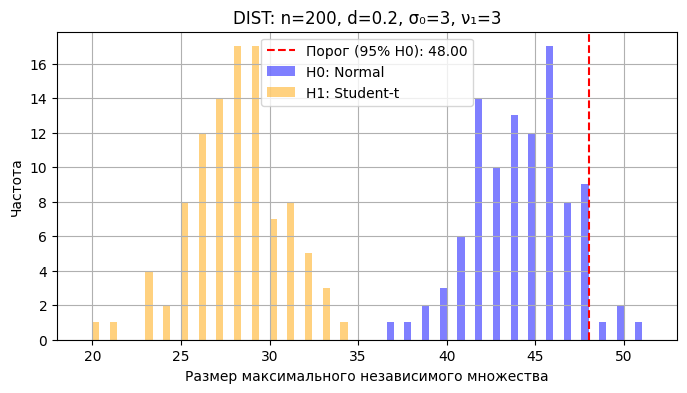

Power (H1): 0.000

=== KNN: n=200, k=4, σ₀=3, ν₁=5 ===


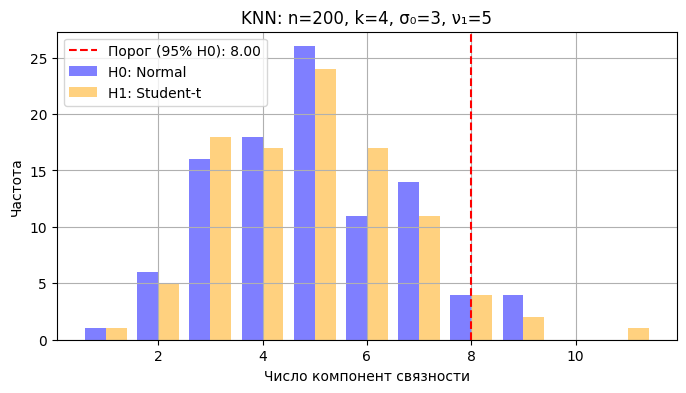

Power (H1): 0.030

=== DIST: n=200, d=0.2, σ₀=3, ν₁=5 ===


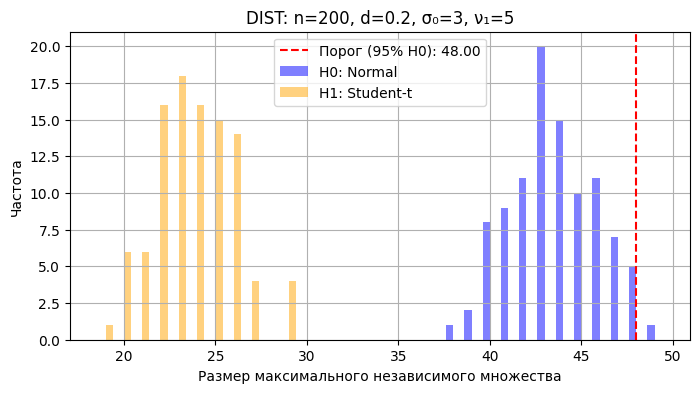

Power (H1): 0.000

=== KNN: n=200, k=4, σ₀=3, ν₁=10 ===


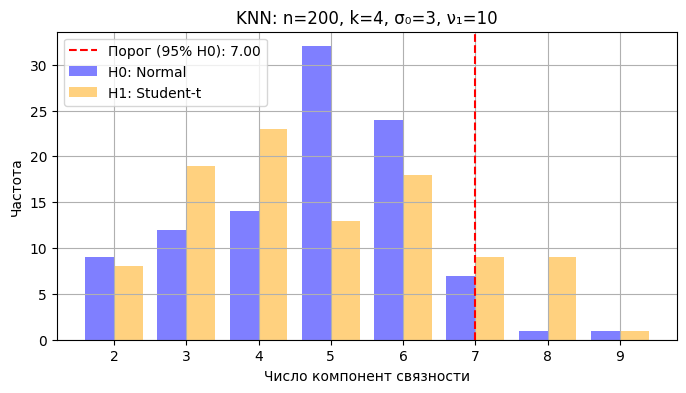

Power (H1): 0.100

=== DIST: n=200, d=0.2, σ₀=3, ν₁=10 ===


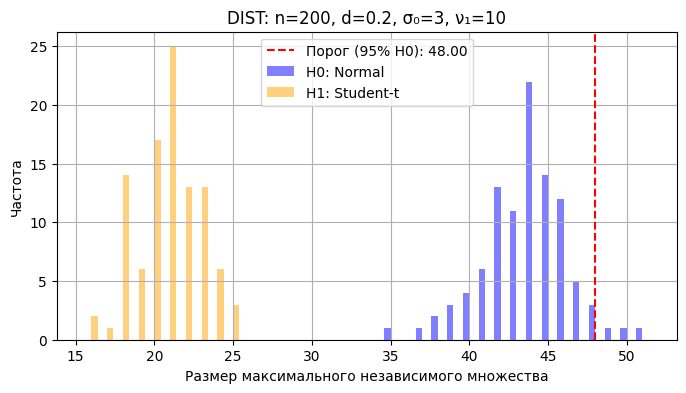

Power (H1): 0.000

=== KNN: n=200, k=4, σ₀=3, ν₁=20 ===


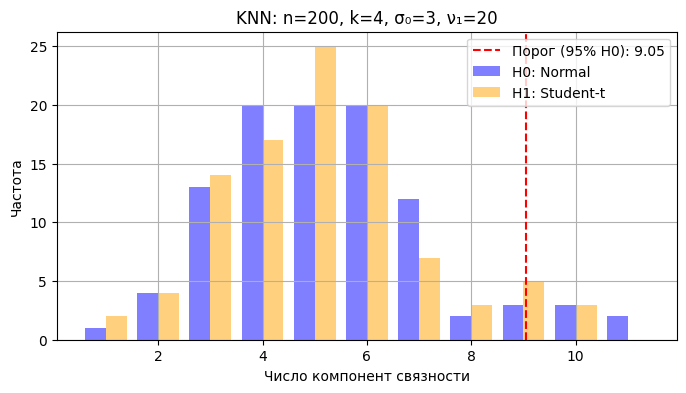

Power (H1): 0.030

=== DIST: n=200, d=0.2, σ₀=3, ν₁=20 ===


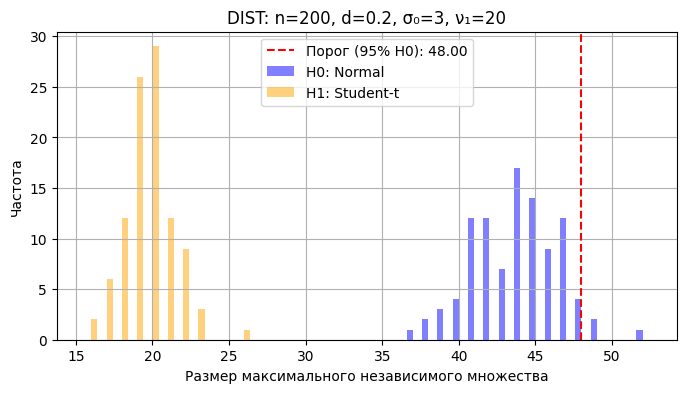

Power (H1): 0.000

=== KNN: n=200, k=4, σ₀=5, ν₁=1.5 ===


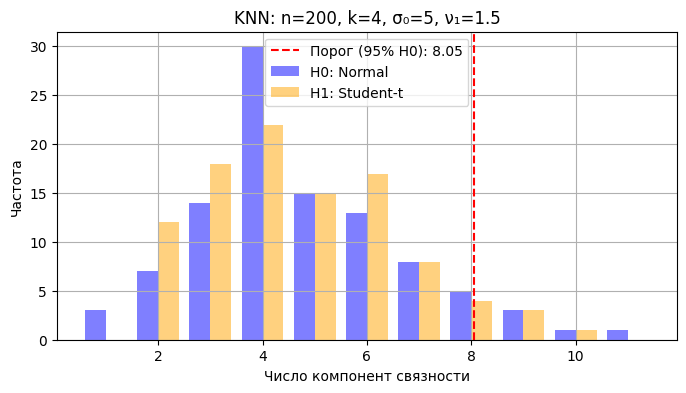

Power (H1): 0.040

=== DIST: n=200, d=0.2, σ₀=5, ν₁=1.5 ===


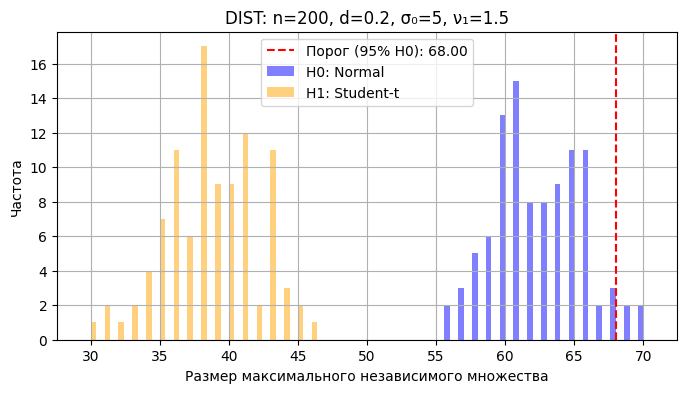

Power (H1): 0.000

=== KNN: n=200, k=4, σ₀=5, ν₁=2 ===


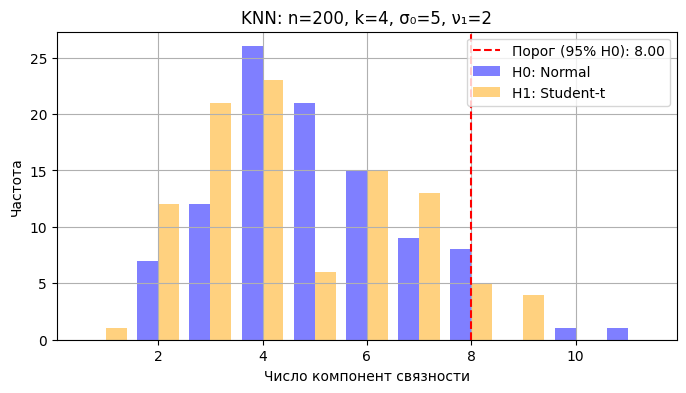

Power (H1): 0.040

=== DIST: n=200, d=0.2, σ₀=5, ν₁=2 ===


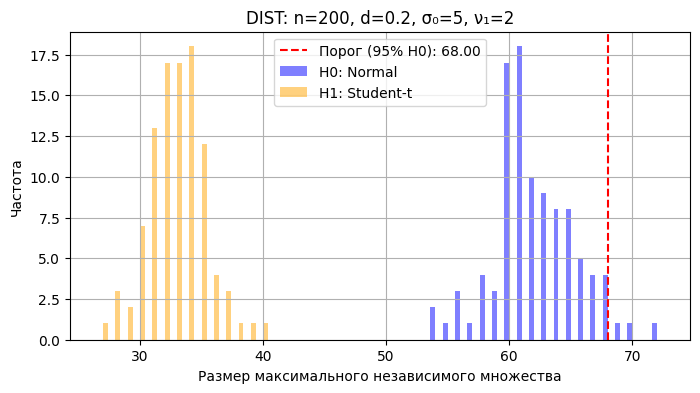

Power (H1): 0.000

=== KNN: n=200, k=4, σ₀=5, ν₁=3 ===


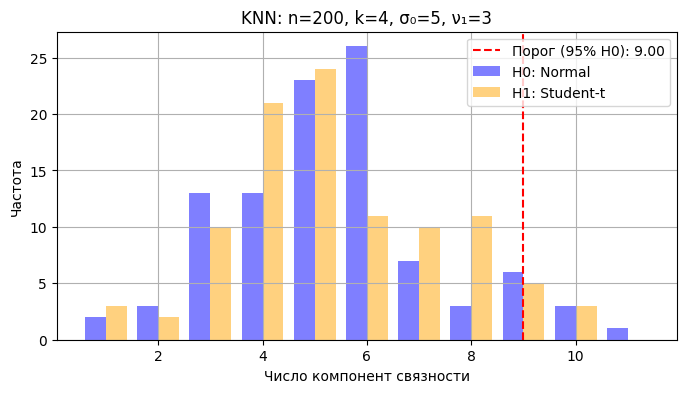

Power (H1): 0.030

=== DIST: n=200, d=0.2, σ₀=5, ν₁=3 ===


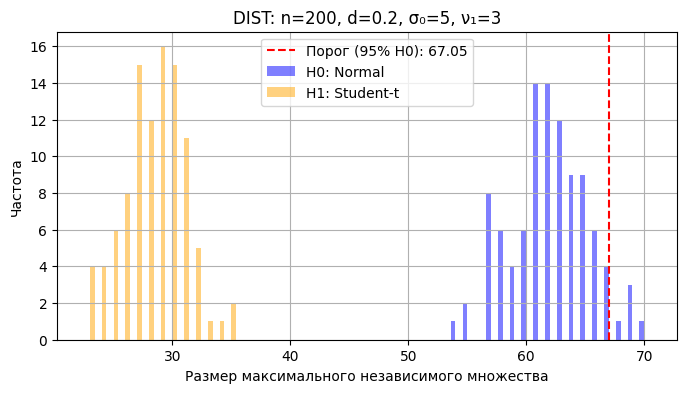

Power (H1): 0.000

=== KNN: n=200, k=4, σ₀=5, ν₁=5 ===


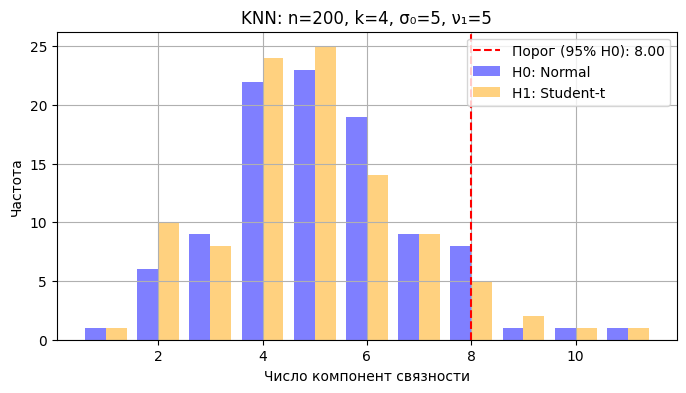

Power (H1): 0.040

=== DIST: n=200, d=0.2, σ₀=5, ν₁=5 ===


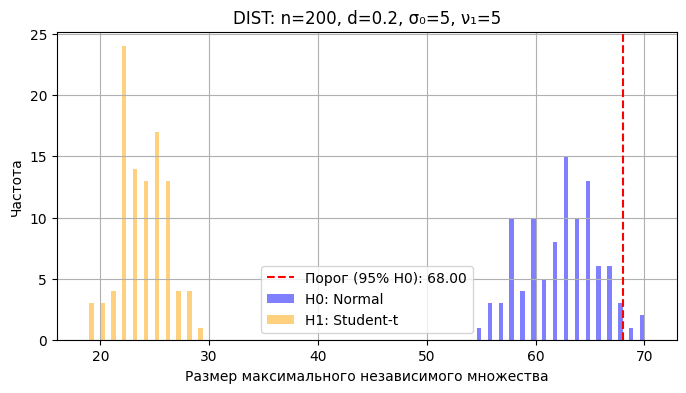

Power (H1): 0.000

=== KNN: n=200, k=4, σ₀=5, ν₁=10 ===


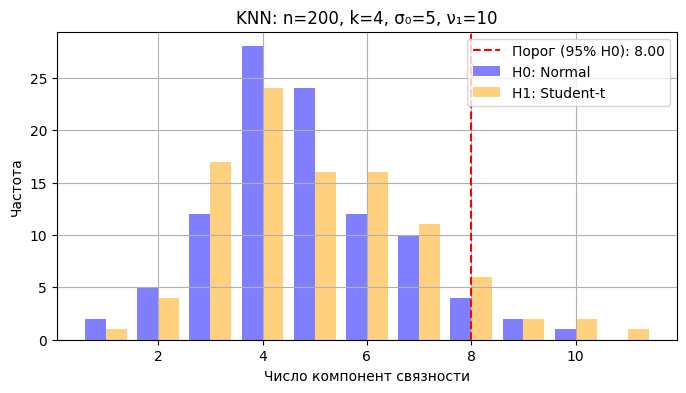

Power (H1): 0.050

=== DIST: n=200, d=0.2, σ₀=5, ν₁=10 ===


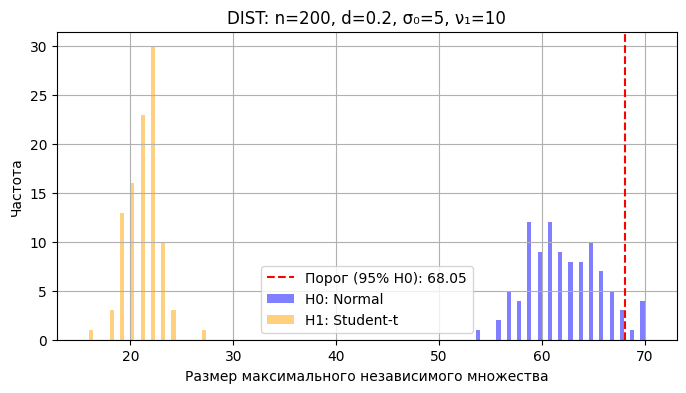

Power (H1): 0.000

=== KNN: n=200, k=4, σ₀=5, ν₁=20 ===


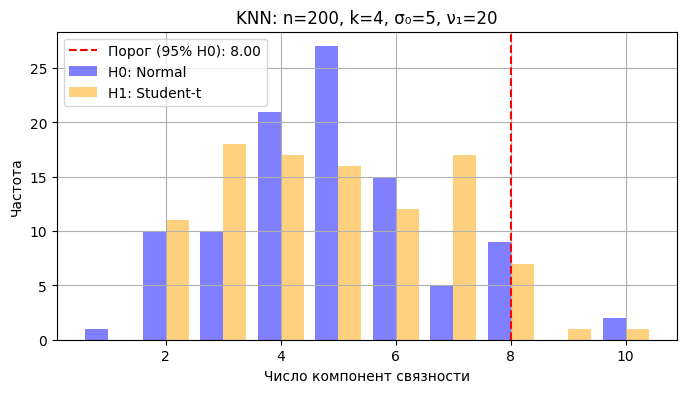

Power (H1): 0.020

=== DIST: n=200, d=0.2, σ₀=5, ν₁=20 ===


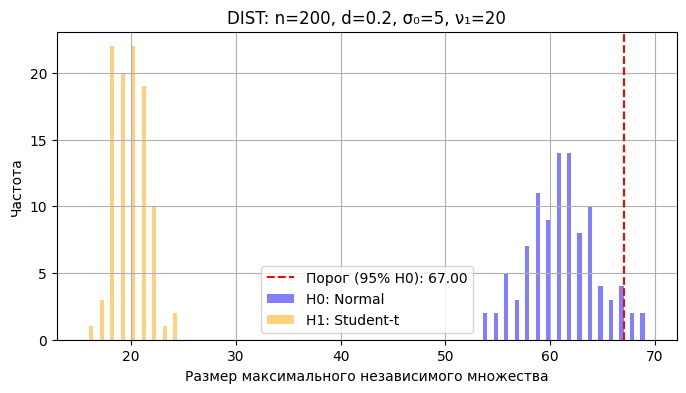

Power (H1): 0.000



In [23]:
n = [200]
k = [4]
d = [0.2]
n_sim = 100

sigma_values = [0.2, 0.5, 0.7, 1, 1.5, 2, 3, 5]
nu_values = [1.5, 2, 3, 5, 10, 20]

df_results = perebiralka(n, k, d, sigma_values, nu_values, n_sim=100)

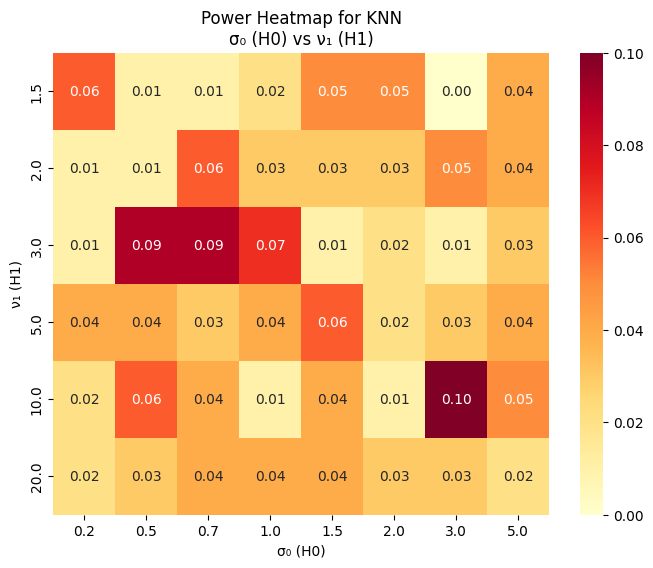

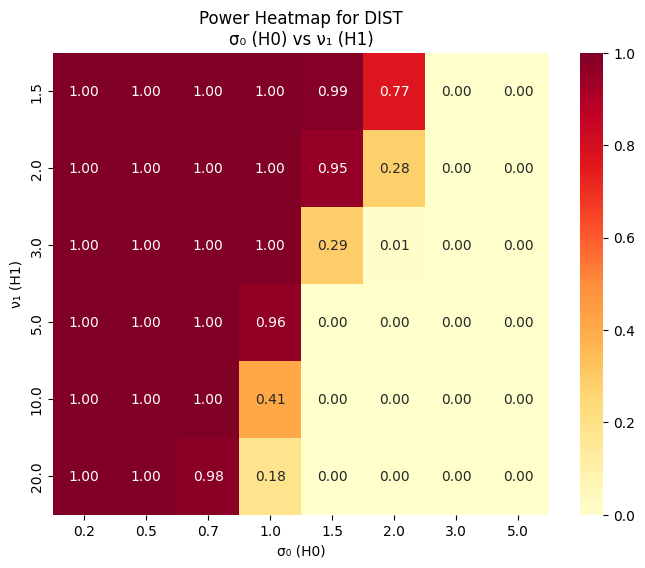

In [24]:
def plot_power_heatmap_sigma_nu(df, graph_type):
    df_plot = df[df['Graph'] == graph_type]
    pivot_power = df_plot.pivot(index='ν₁ (H1)', columns='σ₀ (H0)', values='Power (H1)')
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_power, annot=True, cmap='YlOrRd', fmt=".2f")
    plt.title(f'Power Heatmap for {graph_type}\nσ₀ (H0) vs ν₁ (H1)')
    plt.xlabel('σ₀ (H0)')
    plt.ylabel('ν₁ (H1)')
    plt.show()

plot_power_heatmap_sigma_nu(df_results, 'KNN')

plot_power_heatmap_sigma_nu(df_results, 'DIST')

## Вывод при изменении параметров распределений

- у KNN все еще результаты крайне слабые, мощность в лучшем случае еле перелезла через 0.1
- у DIST видим яркую зависимость от парамтеров H0 и H1: чем меньше H0 и чем меньше H1, тем лучше отрабатывает предсказание. например при H0 = 0.5, мощность всегда равна 1, но при H0 = 2 мощность на приемлемом уровне только при H1 = 1.5, в остальных случаях она почти 0 или равна ему. При этом критерий H0 более сильно влияет на характеристику, ведь при любом H1 есть такой H0, что мощность будет равна 1, но не в обратную сторону.